# GPT-2 Adoption

Code from https://github.com/graykode/gpt-2-Pytorch

In [1]:
import copy
import torch
import math
import torch.nn as nn
from torch.nn.parameter import Parameter


In [2]:
import random
import numpy as np

# Reproducibility
seed = random.randint(0, 2147483647)
np.random.seed(seed)
torch.random.manual_seed(seed)
torch.cuda.manual_seed(seed)

# GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### 
# GPTConfig - HuggingFace style

In [3]:
class GPT2Config(object):
    def __init__(
            self,
            vocab_size_or_config_json_file=50257,
            n_positions=1024,
            n_ctx=1024,
            n_embd=768,
            n_layer=12,
            n_head=12,
            layer_norm_epsilon=1e-5,
            initializer_range=0.02,
            pdrop=0.1,
    ):
        self.vocab_size = vocab_size_or_config_json_file
        self.n_ctx = n_ctx
        self.n_positions = n_positions
        self.n_embd = n_embd
        self.n_layer = n_layer
        self.n_head = n_head
        self.layer_norm_epsilon = layer_norm_epsilon
        self.initializer_range = initializer_range
        self.pdrop = pdrop

#### 
# Wandb managing experiments

In [4]:
import wandb
wandb.init(project="gpt_music_lyrics", entity="tst008")
!wandb on

wandb: Currently logged in as: tst008 (use `wandb login --relogin` to force relogin)


W&B online, running your script from this directory will now sync to the cloud.


#### 
# Creating Model

Layer Norm: $y = \frac{x-E[x]}{\sqrt{Var[x] + \epsilon}} * \gamma + \beta$

- Where x is a mini-batch of input, with dimension `normalized_shape`.
- $\gamma$ and $\beta$ are $\textit{learnable}$ affine transform parameters

In [5]:
class LayerNorm(nn.Module):
    def __init__(self, hidden_size, eps=1e-12):
        """Construct a layernorm module in the TF style (epsilon inside the square root).
        """
        super(LayerNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.bias = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = eps

    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.weight * x + self.bias

In [6]:
batch, sentence_length, embedding_dim = 20, 5, 10
embedding = torch.randn(batch, sentence_length, embedding_dim)
layer_norm = LayerNorm(embedding_dim)
layer_norm(embedding).shape

torch.Size([20, 5, 10])

- Input: $N, C, L$, Output: $N, C, L_o$

$out(N, C_j) =  bias(C_j) + \sum^{C_i - 1}_{k=1}w(C_j, k) * inp(N_i, k)$

In [7]:
class Conv1D(nn.Module):
    def __init__(self, nf, nx):
        super(Conv1D, self).__init__()
        self.nf = nf
        self.nx = nx
        w = torch.empty(nx, nf)
        nn.init.normal_(w, std=0.02)
        self.weight = Parameter(w)
        self.bias = Parameter(torch.zeros(nf))

    def forward(self, x):
        assert self.nx == x.shape[-1], f"Shape mismatched, expected shape: {list(x.shape[:-1])+[self.nx]}, got shape: {list(x.shape)}"
        size_out = x.size()[:-1] + (self.nf,)
        x = torch.addmm(self.bias, x.view(-1, x.size(-1)), self.weight)
        x = x.view(*size_out)
        return x

In [8]:
m = Conv1D(10, 50)
i = torch.randn(20, 16, 50)
m(i).shape

torch.Size([20, 16, 10])

Applies multi-head attention 

- Query: representation of current word used to score against other words
- Key: labels for all potentially relevant words in segment
- Value: Actual word representations. Relevancy of each word is added up to represent current word

Input size, output size??
https://jalammar.github.io/illustrated-gpt2/

In [9]:
class Attention(nn.Module):
    def __init__(self, nx, n_ctx, config, scale=False):
        super(Attention, self).__init__()
        n_state = nx  # in Attention: n_state=768 (nx=n_embd)
        # [switch nx => n_state from Block to Attention to keep identical to TF implem]
        assert n_state % config.n_head == 0
        self.register_buffer("bias", torch.tril(torch.ones(n_ctx, n_ctx)).view(1, 1, n_ctx, n_ctx))
        self.n_head = config.n_head
        self.split_size = n_state
        self.scale = scale
        self.c_attn = Conv1D(n_state * 3, nx)
        self.c_proj = Conv1D(n_state, nx)
        self.attn_drop = nn.Dropout(config.pdrop, inplace=False)
        self.resid_drop = nn.Dropout(config.pdrop, inplace=False)

    def _attn(self, q, k, v):
        w = torch.matmul(q, k)
        if self.scale:
            w = w / math.sqrt(v.size(-1))
        nd, ns = w.size(-2), w.size(-1)
        try:
            b = self.bias[:, :, ns-nd:ns, :ns]
            w = w * b - 1e10 * (1 - b)
            w = nn.Softmax(dim=-1)(w)
        except:
            print(b.shape, w.shape)
            raise
        return w, torch.matmul(w, v)

    def merge_heads(self, x):
        x = x.permute(0, 2, 1, 3).contiguous()
        new_x_shape = x.size()[:-2] + (x.size(-2) * x.size(-1),)
        return x.view(*new_x_shape)  # in Tensorflow implem: fct merge_states

    def split_heads(self, x, k=False):
        new_x_shape = x.size()[:-1] + (self.n_head, x.size(-1) // self.n_head)
        x = x.view(*new_x_shape)  # in Tensorflow implem: fct split_states
        if k:
            return x.permute(0, 2, 3, 1)  # (batch, head, head_features, seq_length)
        else:
            return x.permute(0, 2, 1, 3)  # (batch, head, seq_length, head_features)

    def forward(self, x, layer_past=None):
        # Begin by looking at the shape of all these
#         print(f"x:{x.shape}")
        x = self.c_attn(x)
#         print(f"(after c_attn) x:{x.shape}")
        query, key, value = x.split(self.split_size, dim=2)
#         print(f"query:{query.shape}, key:{key.shape}, value:{value.shape},")
        query = self.split_heads(query)
        key = self.split_heads(key, k=True)
        value = self.split_heads(value)
#         print(f"(after split_heads()) query:{query.shape}, key:{key.shape}, value:{value.shape},")
        if layer_past is not None:
            past_key, past_value = layer_past[0].transpose(-2, -1), layer_past[1]  # transpose back cf below
            key = torch.cat((past_key, key), dim=-1)
            value = torch.cat((past_value, value), dim=-2)
#             print(f"(in if layer_past is not None) query:{query.shape}, key:{key.shape}, value:{value.shape},")
        present = torch.stack((key.transpose(-2, -1), value))  # transpose to have same shapes for stacking
#         print(f"present:{present.shape}")
        w, a = self._attn(query, key, value)
#         print(f"(output of _attn) a:{a.shape}")
        a = self.merge_heads(a)
#         print(f"(output of merge_heads) a:{a.shape}")
        a = self.c_proj(a)
#         print(f"(output of c_proj) a:{a.shape}")
        a = self.resid_drop(a)
#         print(f"(output of resid_drop) a:{a.shape}")
        return a, present, w # Present key and values?

In [10]:
# TODO: Test Masked before softmax, 

In [11]:
w = torch.ones([1, 1, 1024, 1024]) #torch.Size([1, 12, 1760, 1760])
b = torch.ones([1, 12,])
nd, ns = w.size(-2), w.size(-1)
nd, ns

(1024, 1024)

Applies the Gaussian Error Linear Units function:
    
$y = x * \Phi(x)$

where $\Phi(x)$ is the Cumulative Distribution Function for Gaussian Distribution

... tho I'm not seeing that here

In [12]:
def gelu(x):
    return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

In [13]:
gelu(torch.randn(2))

tensor([0.0010, 0.6200])

Conv1D(n_state, n_embd) $\implies$ gelu $\implies$ Conv1D(n_embd, n_state)  

In [14]:
class MLP(nn.Module):
    def __init__(self, n_state, config):  # in MLP: n_state=3072 (4 * n_embd)
        super(MLP, self).__init__()
        nx = config.n_embd
        self.c_fc = Conv1D(n_state, nx)
        self.c_proj = Conv1D(nx, n_state)
        self.act = gelu
        self.dropout = nn.Dropout(config.pdrop)

    def forward(self, x):
        h = self.act(self.c_fc(x))
        h2 = self.c_proj(h)
        h2 = self.dropout(h2)
        return h2

In [15]:
import argparse
config = argparse.Namespace(
    n_embd = 15,
    pdrop = .1,
)
i = torch.randn(10, 3, 15)
mlp = MLP(30, config)
mlp(i).shape

torch.Size([10, 3, 15])

Returns: 
- $x + (LN(x) \implies ATTN(x)) + MLP(x)$
- `present` the cumulative keys and values?

In [16]:
class Block(nn.Module):
    def __init__(self, n_ctx, config, scale=False):
        super(Block, self).__init__()
        nx = config.n_embd
        self.ln_1 = LayerNorm(nx, eps=config.layer_norm_epsilon)
        self.attn = Attention(nx, n_ctx, config, scale)
        self.ln_2 = LayerNorm(nx, eps=config.layer_norm_epsilon)
        self.mlp = MLP(4 * nx, config)

    def forward(self, x, layer_past=None):
        a, present, _ = self.attn(self.ln_1(x), layer_past=layer_past)
        x = x + a
        m = self.mlp(self.ln_2(x))
        x = x + m
        return x, present

In [17]:
# TODO: Test Block

Decoder-only Transformer GPT-2

In [18]:
class GPT2Model(nn.Module):
    def __init__(self, config):
        super(GPT2Model, self).__init__()
        self.n_layer = config.n_layer
        self.n_embd = config.n_embd
        self.n_vocab = config.vocab_size

        self.wte = nn.Embedding(config.vocab_size, config.n_embd)
        self.wpe = nn.Embedding(config.n_positions, config.n_embd)
        
        self.drop = nn.Dropout(config.pdrop, inplace=False)
        
        block = Block(config.n_ctx, config, scale=True)
        self.h = nn.ModuleList([copy.deepcopy(block) for _ in range(config.n_layer)])
        self.ln_f = LayerNorm(config.n_embd, 
                              eps=config.layer_norm_epsilon)

    def set_embeddings_weights(self, model_embeddings_weights):
        embed_shape = model_embeddings_weights.shape
        self.decoder = nn.Linear(embed_shape[1], embed_shape[0], bias=False)
        self.decoder.weight = model_embeddings_weights  # Tied weights

    def forward(self, input_ids, 
                position_ids=None, 
                token_type_ids=None, 
                past=None):
        if past is None:
            past_length = 0
            past = [None] * len(self.h)
        else:
            past_length = past[0][0].size(-2)
        if position_ids is None:
            position_ids = torch.arange(past_length, input_ids.size(-1) + past_length, dtype=torch.long,
                                        device=input_ids.device)
            position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

        input_shape = input_ids.size()
        input_ids = input_ids.view(-1, input_ids.size(-1))
        position_ids = position_ids.view(-1, position_ids.size(-1))

        inputs_embeds = self.wte(input_ids)
        position_embeds = self.wpe(position_ids)
        if token_type_ids is not None:
            token_type_ids = token_type_ids.view(-1, token_type_ids.size(-1))
            token_type_embeds = self.wte(token_type_ids)
        else:
            token_type_embeds = 0
        hidden_states = inputs_embeds + position_embeds + token_type_embeds
        presents = []
        for block, layer_past in zip(self.h, past):
            hidden_states, present = block(hidden_states, layer_past)
            presents.append(present)
        hidden_states = self.drop(hidden_states)
        hidden_states = self.ln_f(hidden_states)
        output_shape = input_shape + (hidden_states.size(-1),)
        return hidden_states.view(*output_shape), presents

In [19]:
# TODO: Initial test

In [20]:
class GPT2LMHead(nn.Module):
    def __init__(self, model_embeddings_weights, config):
        super(GPT2LMHead, self).__init__()
        self.n_embd = config.n_embd
        self.set_embeddings_weights(model_embeddings_weights)

    def set_embeddings_weights(self, model_embeddings_weights):
        embed_shape = model_embeddings_weights.shape
        self.decoder = nn.Linear(embed_shape[1], embed_shape[0], bias=False)
        self.decoder.weight = model_embeddings_weights  # Tied weights

    def forward(self, hidden_state):
        # Truncated Language modeling logits (we remove the last token)
        # h_trunc = h[:, :-1].contiguous().view(-1, self.n_embd)
        lm_logits = self.decoder(hidden_state)
        return lm_logits

In [21]:
class GPT2LMHeadModel(nn.Module):
    def __init__(self, config):
        super(GPT2LMHeadModel, self).__init__()
        self.transformer = GPT2Model(config)
        self.lm_head = GPT2LMHead(self.transformer.wte.weight, config)

    def set_tied(self):
        """ Make sure we are sharing the embeddings
        """
        self.lm_head.set_embeddings_weights(self.transformer.wte.weight)

    def forward(self, input_ids, position_ids=None, token_type_ids=None, lm_labels=None, past=None):
        hidden_states, presents = self.transformer(input_ids, position_ids, token_type_ids, past)
        lm_logits = self.lm_head(hidden_states)
        if lm_labels is not None:
            shift_logits = lm_logits[..., :-1, :].contiguous()
            shift_labels = lm_labels[..., 1:].contiguous()
            loss_fct = nn.CrossEntropyLoss()
#             loss_fct = nn.CrossEntropyLoss(ignore_index=-1)
#             loss = loss_fct(lm_logits.view(-1, lm_logits.size(-1)), lm_labels.view(-1))
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
            return loss, lm_logits, presents
        return lm_logits, presents

#### 
# Encoder

In [22]:
import os
import json
import regex as re
from os.path import expanduser
# from functools import lru_cache

# @lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))

def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs

class Encoder:
    def __init__(self, encoder, bpe_merges, errors='replace'):
        self.encoder = encoder
        self.decoder = {v:k for k,v in self.encoder.items()}
        self.errors = errors # how to handle errors in decoding
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v:k for k, v in self.byte_encoder.items()}
        self.bpe_ranks = dict(zip(bpe_merges, range(len(bpe_merges))))
        self.cache = {}
        self.special_tokens = []

        # Should haved added re.IGNORECASE so BPE merges can happen for capitalized versions of contractions
        self.re_pattern = r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+"""
        self.pat = re.compile(self.re_pattern)
        
    def add_special_token(self, s):
        if s in self.special_tokens:
            print(f"Token {s} already added")
        self.special_tokens.append(s)
        if s in self.encoder: 
            # Special token already known, but regex pattern cannot capture fully yet
            pass
        else:
            self.encoder[s] = len(self.encoder)+1
            self.decoder[len(self.encoder)+1] = s
        s = s.replace("|", r"\|")
        self.re_pattern = " " + s + "|" + self.re_pattern
        self.pat = re.compile(self.re_pattern)

    def bpe(self, token):
        # Also don't split on special tokens
        if token in self.special_tokens:
            return token
        if token in self.cache:
            return self.cache[token]
        word = tuple(token)
        pairs = get_pairs(word)

        if not pairs:
            return token

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens

    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors=self.errors)
        return text

def get_encoder():
    home = expanduser("~")
    with open(os.path.join(home, 'data/GPT2/encoder.json'), 'r') as f:
        encoder = json.load(f)
    with open(os.path.join(home, 'data/GPT2/vocab.bpe'), 'r', encoding="utf-8") as f:
        bpe_data = f.read()
    bpe_merges = [tuple(merge_str.split()) for merge_str in bpe_data.split('\n')[1:-1]]
    enc = Encoder(
        encoder=encoder,
        bpe_merges=bpe_merges,
    )
    enc.add_special_token("<|endoftext|>")
    enc.add_special_token("<|GOAL|>")
    enc.add_special_token("<|PROOFSTEP|>")
    print(enc.special_tokens)
    return enc

vocab_size_or_config_json_file=50257,
n_positions=1024,
n_ctx=1024,
n_embd=768,
n_layer=12,
n_head=12,
layer_norm_epsilon=1e-5,
initializer_range=0.02,

#### 
# Loading model

In [23]:
# Load Model
# enc = get_encoder()
config = GPT2Config()
model = GPT2LMHeadModel(config)
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm()
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_drop): Dropout(p=0.1, inplace=False)
          (resid_drop): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm()
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_drop): Dropout(p=0.1, inplace=False)
          (resid_drop): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
   

In [24]:
state_dict = torch.load('gpt2-pytorch_model.bin', map_location='cpu' if not torch.cuda.is_available() else None)

old_keys = []
new_keys = []
for key in state_dict.keys():
    new_key = None
    if key.endswith(".g"):
        new_key = key[:-2] + ".weight"
    elif key.endswith(".b"):
        new_key = key[:-2] + ".bias"
    elif key.endswith(".w"):
        new_key = key[:-2] + ".weight"
    if new_key:
        old_keys.append(key)
        new_keys.append(new_key)
for old_key, new_key in zip(old_keys, new_keys):
    state_dict[new_key] = state_dict.pop(old_key)
# model.load_state_dict(state_dict)
missing_keys = []
unexpected_keys = []
error_msgs = []
# copy state_dict so _load_from_state_dict can modify it
metadata = getattr(state_dict, "_metadata", None)
state_dict = state_dict.copy()
if metadata is not None:
    state_dict._metadata = metadata

def load(module, prefix=""):
    local_metadata = {} if metadata is None else metadata.get(prefix[:-1], {})
    module._load_from_state_dict(
        state_dict, prefix, local_metadata, True, missing_keys, unexpected_keys, error_msgs
    )
    for name, child in module._modules.items():
        if child is not None:
            load(child, prefix + name + ".")

start_model = model
if hasattr(model, "transformer") and all(not s.startswith('transformer.') for s in state_dict.keys()):
    start_model = model.transformer
load(start_model, prefix="")

model.set_tied()
type(model) == GPT2LMHeadModel

True

#### 
# Sampling a sequence

In [25]:
import torch
import torch.nn.functional as F
from tqdm import trange

def top_k_logits(logits, k):
    if k == 0:
        return logits
    values, _ = torch.topk(logits, k)
    min_values = values[:, -1]
    return torch.where(logits < min_values, torch.ones_like(logits, dtype=logits.dtype) * -1e10, logits)

def sample_sequence(model, length, start_token=None, batch_size=None, context=None, temperature=1, top_k=0, device='cuda', sample=True):
    if start_token is None:
        assert context is not None, 'Specify exactly one of start_token and context!'
        context = torch.tensor(context, device=device, dtype=torch.long).unsqueeze(0).repeat(batch_size, 1)
    else:
        assert context is None, 'Specify exactly one of start_token and context!'
        context = torch.full((batch_size, 1), start_token, device=device, dtype=torch.long)
    prev = context
    output = context
    past = None
    with torch.no_grad():
        for i in range(length):
#             print(prev.shape)
#             raise
            logits, past = model(prev, past=past)
            logits = logits[:, -1, :] / temperature
            logits = top_k_logits(logits, k=top_k)
            log_probs = F.softmax(logits, dim=-1)
            if sample:
                prev = torch.multinomial(log_probs, num_samples=1)
            else:
                _, prev = torch.topk(log_probs, k=1, dim=-1)
            output = torch.cat((output, prev), dim=1)
    return output

# def sample_sequence(model, length, start_token=None, batch_size=None, context=None, temperature=1, top_k=0, device='cuda', sample=True):
#     if start_token is None:
#         assert context is not None, 'Specify exactly one of start_token and context!'
#         context = torch.tensor(context, device=device, dtype=torch.long).unsqueeze(0).repeat(batch_size, 1)
#     else:
#         assert context is None, 'Specify exactly one of start_token and context!'
#         context = torch.full((batch_size, 1), start_token, device=device, dtype=torch.long)
#     prev = context
#     output = context
#     past = None
#     with torch.no_grad():
#         for i in range(length):
# #             print(prev.shape)
# #             raise
#             loss, logits, past = model(prev,
#                                  lm_labels=prev,
#                                  past=past)
#             print(loss)
#             logits = logits[:, -1, :] / temperature
#             logits = top_k_logits(logits, k=top_k)
#             log_probs = F.softmax(logits, dim=-1)
#             if sample:
#                 prev = torch.multinomial(log_probs, num_samples=1)
#             else:
#                 _, prev = torch.topk(log_probs, k=1, dim=-1)
#             output = torch.cat((output, prev), dim=1)
#     return output

#### 
# Try running

In [26]:
# TODO: Turn into notebook style

import os
import sys
import torch
import random
import argparse
import numpy as np

args = argparse.Namespace(
    text="It was a bright cold day in April.",
    quiet=False,
    nsamples=1,
    unconditional=False,
    batch_size=1,
    length=200,
    temperature=0.7,
    top_k=40,
)

if args.quiet is False:
    print(args)

if args.batch_size == -1:
    args.batch_size = 1
assert args.nsamples % args.batch_size == 0

# Load Model
enc = get_encoder()
model.to(device)
model.eval()

if args.length == -1:
    args.length = config.n_ctx // 2
elif args.length > config.n_ctx:
    raise ValueError("Can't get samples longer than window size: %s" % config.n_ctx)

print(args.text)
context_tokens = enc.encode(args.text)

generated = 0
for _ in range(args.nsamples // args.batch_size):
    out = sample_sequence(
        model=model, length=args.length,
        context=context_tokens  if not  args.unconditional else None,
        start_token=enc.encoder['<|endoftext|>'] if args.unconditional else None,
        batch_size=args.batch_size,
        temperature=args.temperature, top_k=args.top_k, device=device
    )
    out = out[:, len(context_tokens):].tolist()
    for i in range(args.batch_size):
        generated += 1
        text = enc.decode(out[i])
        if args.quiet is False:
            print("=" * 40 + " SAMPLE " + str(generated) + " " + "=" * 40)
            print(text)
            
type(model) == GPT2LMHeadModel

Namespace(batch_size=1, length=200, nsamples=1, quiet=False, temperature=0.7, text='It was a bright cold day in April.', top_k=40, unconditional=False)
['<|endoftext|>', '<|GOAL|>', '<|PROOFSTEP|>']
It was a bright cold day in April.
======================================== SAMPLE 1 ========================================
 A little over a year before he was killed in a gunfight with a SWAT team, James G. was working as an accountant at a local bank. He and his partner had been working as an accounting and tax analyst for a time. But when he was shot, he said, he was convinced it was an accident. He called the FBI.

"The FBI told me they would investigate it, but I didn't want to let them know," he said. "They only told me there were a couple of dozen people with guns on the street, and it was a very frightening thing that happened. I would never have believed they would do something like this."

Advertisement Continue reading the main story

James G. was killed Jan. 8, 2004. No one in

True

use an 80-5-15 train-validation-test split. We split all
datapoints deterministically by theorem name, by hashing
each name to a float in (0, 1)

For fine-tuning a model, we load saved parameters but reinitialize the optimizer. We start each training for a fixed
number of tokens (defining the cosine schedule) and record
the number of tokens consumed as we reach a minimal validation loss. We use the minimum validation loss snapshot
to evaluate each model on our held-out test set.


#### 
# Fine Tuning

https://towardsdatascience.com/how-to-fine-tune-gpt-2-for-text-generation-ae2ea53bc272

In [27]:
import pandas as pd

In [28]:
# Get data
lyrics = pd.read_csv('lyrics-data.csv')
lyrics = lyrics[lyrics['Idiom']=='ENGLISH']
# Only keep popular artists, with genre Rock/Pop and popularity high enough
artists = pd.read_csv('artists-data.csv')
artists = artists[(artists['Genre'].isin(['Rock'])) & (artists['Popularity']>5)]

df = lyrics.merge(artists[['Artist', 'Genre', 'Link']], 
                  left_on='ALink', right_on='Link', how='inner')
df = df.drop(columns=['ALink','SLink','Idiom','Link'])
#Drop the songs with lyrics too long (after more than 1024 tokens, does not work)
df = df[df['Lyric'].apply(lambda x: len(x.split(' ')) < 350 and len(x.split(' ')) > 20)]
df.head()

,SName,Lyric,Artist,Genre
0,What's Up,Twenty-five years and my life is still. Trying...,4 Non Blondes,Rock
1,Spaceman,Starry night bring me down. Till I realize the...,4 Non Blondes,Rock
2,Pleasantly Blue,Every time you wake in the mornin'. And you st...,4 Non Blondes,Rock
3,Train,What ya gonna do child. When your thoughts are...,4 Non Blondes,Rock
4,Calling All The People,"How can you tell, when your wellness is not we...",4 Non Blondes,Rock


In [29]:
# import nltk
# import seaborn as sns
# # nltk.download('punkt')
# # get rough token count distribution
# doc_lengths = []
# for row in df['Lyric']:   
#     tokens = nltk.word_tokenize(row)
#     doc_lengths.append(len(tokens))
# doc_lengths = np.array(doc_lengths)
# sns.distplot(doc_lengths)

In [30]:
from torch.utils.data import Dataset

In [31]:
class SongLyrics(Dataset):
    
    def __init__(self, df, tokenizer, truncation=True, gpt2_type="gpt2", max_length=1024):
        self.tokenizer = tokenizer
        self.input_ids = []
#         self.attn_masks = []

        for row in df['Lyric']:
            toks = self.tokenizer.encode(row + '<|endoftext|>') 
            self.input_ids.append(torch.tensor(toks[:max_length]))
#             self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
        
    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx]#, self.attn_masks[idx] 
    
#     def print_special_ids(self):
#         print("The beginning of sequence token {} token has the id {}".format(
#             self.tokenizer.convert_ids_to_tokens(self.tokenizer.bos_token_id), 
#             self.tokenizer.bos_token_id))
#         print("The end of sequence token {} has the id {}".format(
#             self.tokenizer.convert_ids_to_tokens(self.tokenizer.eos_token_id), 
#             self.tokenizer.eos_token_id))

In [32]:
from transformers import (AdamW, 
                          get_linear_schedule_with_warmup)

In [33]:
from torch.utils.data import RandomSampler, SequentialSampler

# Dataset
gpt2_type='gpt2'
tokenizer = get_encoder()
dataset = SongLyrics(df, tokenizer, gpt2_type=gpt2_type)

['<|endoftext|>', '<|GOAL|>', '<|PROOFSTEP|>']


In [34]:
from torch.utils.data import random_split

# Split into train, validation and test set: 80 - 5 - 15
train_size = int(0.8 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

9,953 training samples
  622 validation samples
1,867 test samples


In [35]:
text="It was a bright cold day in April."
quiet=False
nsamples=1
unconditional=False
batch_size=1
gradient_acc_steps = 32
length=-1
temperature=0.7
top_k=40

epochs=21
lr=1e-5
warmup_steps=200
epsilon = 1e-8

output_dir="./models" 
output_prefix="wreckgar"
test_mode=False
save_model_on_epoch=True
sample_every = 100 #sample output every 100 steps

# device=torch.device("cpu")
# model = model.cpu()

In [36]:
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler, SequentialSampler

# Create the DataLoaders for our datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
# For validation and test the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [37]:
# Checkpoint model for resuming

import os
from os.path import isfile, join
import re
import json

def load_checkpoint(model, config, output_dir, output_prefix):
    files = []
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Creating output directory {output_dir}")
    else:    
        files = [f for f in os.listdir(output_dir) if isfile(join(output_dir, f))]

    # Find training stats
    stats_filename = "stats.json"
    if stats_filename in files:
        with open(os.path.join(output_dir, stats_filename), 'r') as f:
            training_stats = json.load(f)
    else:
        training_stats = []
    print(f"Length of current stats file: {len(training_stats)}\n")

    # Find checkpoints
    r = re.compile(f"{output_prefix}-[0-9]*.pt")
    model_files = list(filter(r.match, files))
    epochs_list = [int(x[ len(output_prefix)+1 : -3 ]) for x in model_files]
    if epochs_list:
        current_epoch = max(epochs_list)
        min_val_loss = min([x["Valid. Loss"] for x in training_stats])
        model = GPT2LMHeadModel(config)
        model.load_state_dict(
                torch.load(os.path.join(output_dir, f"{output_prefix}-{current_epoch}.pt"))
        )
        print(f"Checkpoint #{current_epoch} found, with min_val_loss of {min_val_loss:.3f}, resuming.")
    else:
        current_epoch = 0
        min_val_loss = float("inf")
        print(f"Checkpoint not found, starting from epoch #{current_epoch}, min_val_loss of {min_val_loss:.3f}.")
    return model, current_epoch, min_val_loss, training_stats

config = GPT2Config()
config.vocab_size += 2 # 2 new tokens
model, current_epoch, min_val_loss, training_stats = load_checkpoint(model, config, output_dir, output_prefix)
type(model) == GPT2LMHeadModel

Length of current stats file: 0

Checkpoint not found, starting from epoch #0, min_val_loss of inf.


True

In [38]:
device = torch.device("cuda")
model = model.cuda()

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = lr,
                  eps = epsilon
                )

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = (len(train_dataloader) // gradient_acc_steps + 1) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

print(f"Number of warmup steps: {warmup_steps}\nTotal steps: {total_steps}")
type(model) == GPT2LMHeadModel

Number of warmup steps: 200
Total steps: 6552


True

In [39]:
import time
import datetime
from tqdm import tqdm, trange

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [40]:
import  matplotlib.pyplot as plt
# For sampling
def display_attn_and_confidence(model, context_text):
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output[2].detach()
        return hook
    
    context = enc.encode(context_text)
    context = torch.tensor(context, device=device, dtype=torch.long).unsqueeze(0)

    # Getting attention outputs
    handles = [
        model.transformer.h[x].attn.register_forward_hook(get_activation(f'attn_{x}'))
            for x in range(12)
    ]

    # Display next token confidence
    prev = context
    with torch.no_grad():
        logits, past = model(prev)
        logits = logits[:, -1, :] / 0.7
        logits = top_k_logits(logits, k=10)
        log_probs = F.softmax(logits, dim=-1)
        values, prev = torch.topk(log_probs, k=10, dim=-1)

    prev = prev.tolist()
    for i in range(len(prev[0])):
        text = enc.decode([prev[0][i]])
        print(f"{text} -> {values[0][i].item()}")
    [handle.remove() for handle in handles]

    # Visualize attention maps
    idx = 0
    input_data = np.arange(context.shape[-1])
    attn_maps = [[(torch.sum(activation[f'attn_{x}'], dim=1)/12).detach().cpu().numpy() 
                         for x in range(12)]]
    num_heads = 12
    num_layers = 1
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):        
            im = ax[row][column].imshow(attn_maps[row][column][0], origin='upper', vmin=0, vmax=1, cmap='bone')
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {column+1}")
            context_words = [enc.decode([x]).strip(' ') for x in context.cpu().numpy()[0]]
            if column == 0:
                ax[row][column].set_yticklabels(context_words)
            ax[row][column].set_xticklabels(context_words, rotation=90)

    fig.subplots_adjust(hspace=0.6)
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()

2it [00:00, 17.58it/s]


======== Epoch 1 / 21 ========
Training...


3199it [02:22, 23.25it/s]

  Step 3,200  of  9,953. Loss: 2.2067947387695312.   Elapsed: 0:02:22.
>text.getAttribute("text"): text = text[-1].text() if (text.getAttribute("text"): font_family = (text.getAttribute("font_family"))) if (text.getAttribute("text"): font_size = (text.getAttribute("font_size"))) if (text.getAttribute("text"): font_style = FontStyle(text.getAttribute("font_style"))) if (text.getAttribute("text"): font_height = text.getAttribute("font_height"))) text.setAttribute("text",FontStyle(text.getAttribute("font_style"))) return text.append(_text) text = text.getAttribute("text",FontStyle(text.getAttribute("font_style"))) return "\"" return text.append(_text) return Text() endfunction

RAW Paste Data

def __
 who -> 0.7840346097946167
 that -> 0.0744779109954834
 I -> 0.06253274530172348
 you -> 0.03470554202795029
 with -> 0.021662075072526932
 thing -> 0.010480610653758049
 in -> 0.0038482840172946453
 and -> 0.003033461980521679
 to -> 0.0026582968421280384
 of -> 0.002566484035924077


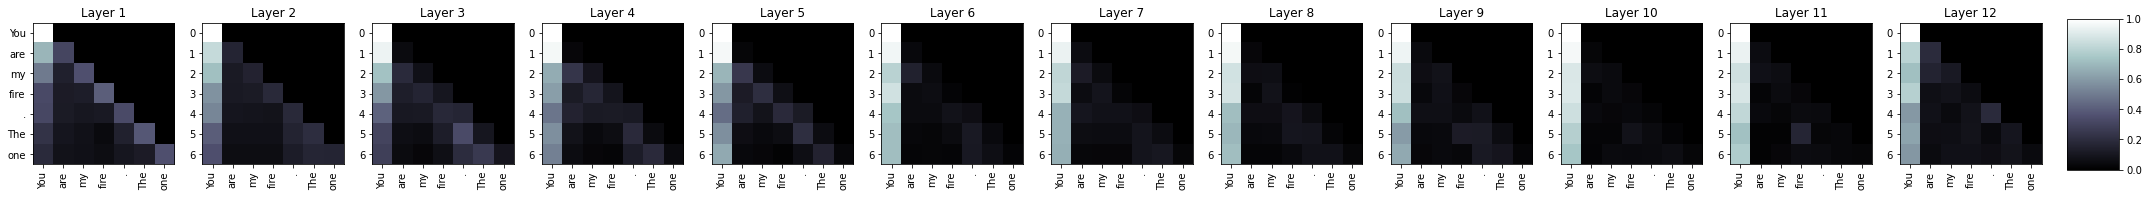

6398it [04:53, 22.36it/s]

  Step 6,400  of  9,953. Loss: 3.8945603370666504.   Elapsed: 0:04:54.
>Sidney and her boyfriend, Josh, had taken a couple of flights to England this week for a little-known concert in Manchester. She's done some shopping in Manchester, but couldn't seem to find his favourite hotel. There's a pub in Manchester called The Oakenfold, and she found a way back to the real place.

As it turns out, she's spent the past couple of weeks searching for a hotel she can get herself into. As she goes in for a last minute night, it's not quite the hotel. It's the one she has to hide in a corner.

In the early hours, they got into a fight. They've been on the go for so long it's almost like you're going into a movie. She says, "It's been so long that I don't even want to sleep in a hotel at all."

But she's determined to find the sweet spot if she
 who -> 0.7136647701263428
 that -> 0.11128803342580795
 I -> 0.08779929578304291
 you -> 0.046990204602479935
 with -> 0.01980013959109783
 thing -> 0.004

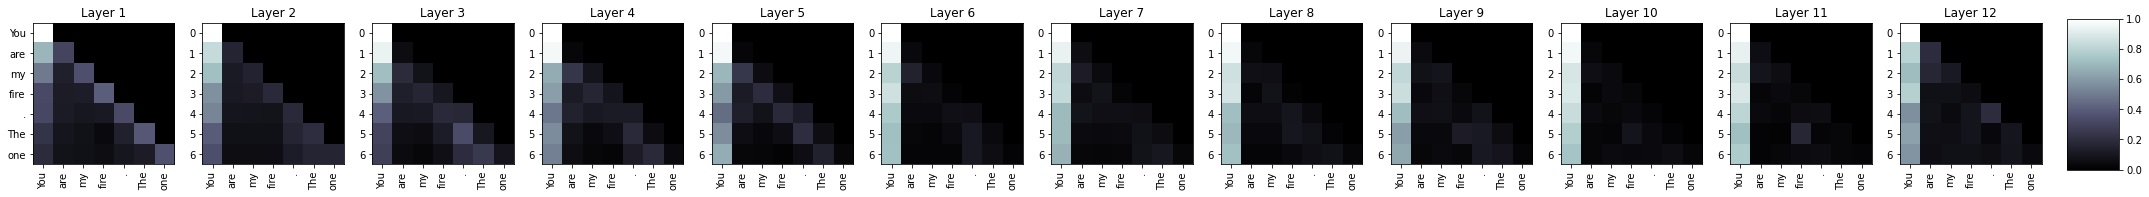

9600it [07:27, 18.42it/s]

  Step 9,600  of  9,953. Loss: 2.4706356525421143.   Elapsed: 0:07:28.
> round the world. I knew it, for now I think it's broken. I saw it, but it's broken. And now I still doubt it. It's broken. I see it, but it's broken. And now I still doubt it. It's broken. I see it, but it's broken. And now I still doubt it. It's broken. [8:40:54 PM] Daphne: I know, but it's broken. I saw it. But it's broken. [8:40:54 PM] Daphne: I know it, but it's broken. I saw it, but it's broken. [8:40:54 PM] Daphne: I know it, but it's broken. I saw it, but it's broken. [8:40:54 PM] Daphne: I know it, but it's broken. I saw it, but it
 who -> 0.6134127974510193
 that -> 0.15923276543617249
 I -> 0.1300155520439148
 you -> 0.05735042691230774
 with -> 0.020901139825582504
 thing -> 0.004289435222744942
 to -> 0.004204801749438047
 in -> 0.0038783762138336897
 of -> 0.003534805728122592
 and -> 0.0031799618154764175


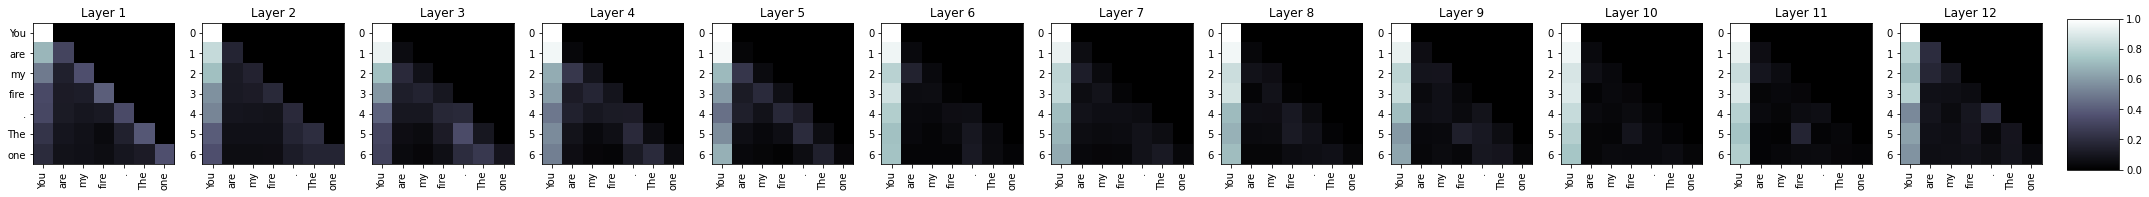

9953it [07:47, 21.28it/s]



  Average training loss: 2.76
  Training epoch took: 0:07:48

Running Validation...
  Validation Loss: 2.58
  Validation took: 0:00:09


2it [00:00, 17.58it/s]


======== Epoch 2 / 21 ========
Training...


3198it [02:32, 21.57it/s]

  Step 3,200  of  9,953. Loss: 2.611567974090576.   Elapsed: 0:02:33.
> this work. We are trying to make this happen. We are trying to make this happen. We are trying to make this happen. We are trying to make this happen. We are hoping some will come along. We are looking for people to help us. We have been looking for people to help us. We have been looking for people to help us.We are coming up on you. We are coming up on you. We are coming up on you. We are coming up on you. We are coming up on you. We are coming up on you. We are coming up on you. We are coming up on you. We are coming up on you. We are coming up on you. We are coming up on you. We are coming up on you. We are coming up on you. We are coming up on you. We are coming up on you. We are coming up on you. We are coming up on you. We
 who -> 0.6493845582008362
 that -> 0.15439894795417786
 I -> 0.11468441039323807
 you -> 0.0442529134452343
 with -> 0.01679382100701332
 and -> 0.004778767470270395
 to -> 0.004728862550

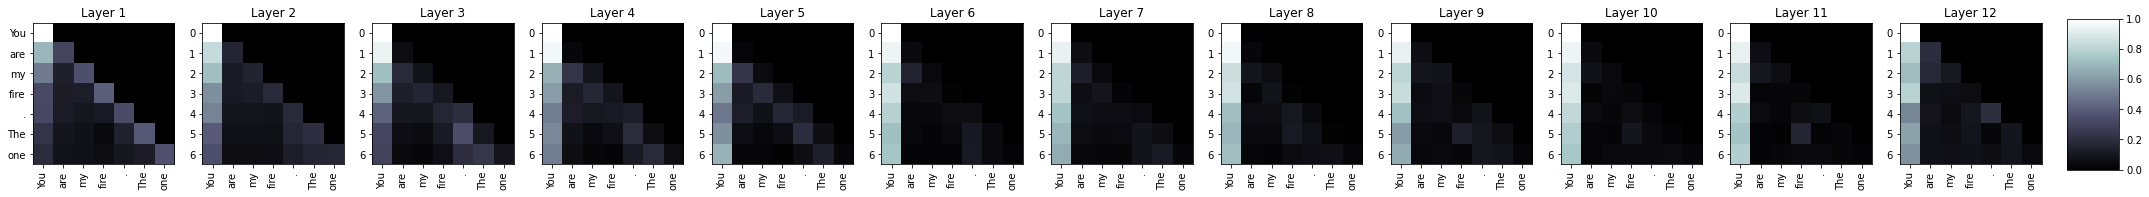

6400it [05:07, 20.70it/s]

  Step 6,400  of  9,953. Loss: 2.972930908203125.   Elapsed: 0:05:08.
> I'll always believe. You'll never know. But that I love you. You'll always be the good boy. All the love I give you. You'll always be the good boy. I love you. So sad. For the father that gave me. What my sister gave me. He gave me. I think I'll be so happy. When I'll grow up again. All the hope. I'll never forget. But that I love you. You'll always be the good boy. All the love I give you. You'll always be the good boy. Oh boy I love you. I thought of how you'd change. I was hoping. Just be so happy. All the hope. I'll never forget. The love that kept me afloat. You'll never see. You'll never be the good boy. Oh boy I love you. I thought of how you'd change. I was hoping. Just be so happy. I
 who -> 0.5535186529159546
 that -> 0.1952439546585083
 I -> 0.14765922725200653
 you -> 0.0684320479631424
 with -> 0.014542149379849434
 in -> 0.00499783456325531
 and -> 0.004208405967801809
 to -> 0.0040536741726100445
 th

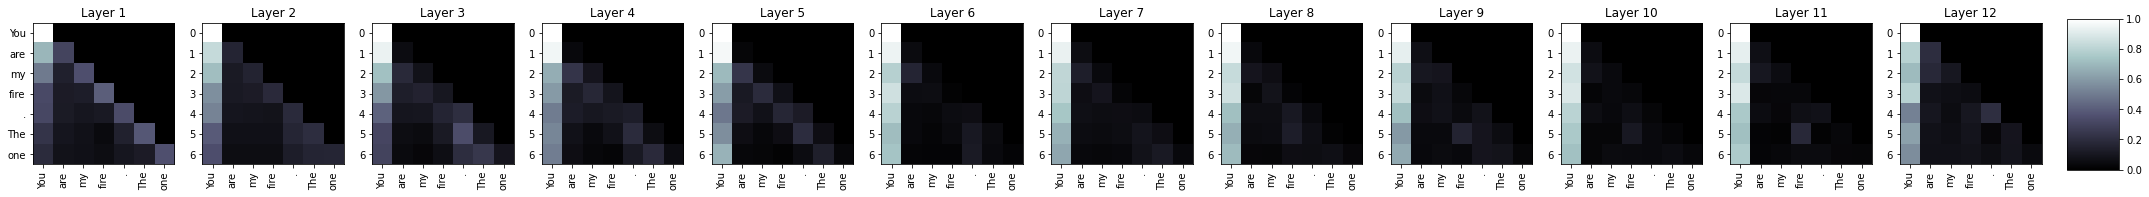

9598it [07:43, 20.92it/s]

  Step 9,600  of  9,953. Loss: 3.4929311275482178.   Elapsed: 0:07:43.
> heavens. And take your breath away. Or take the place you are in now. You'll learn the tricks of fortune. If you don't see the path. And you don't know the path. And you know the trick. You'll do the same before. A couple of hours, two days, two weeks. And there'll be no turning back. If you don't see the path. And you don't know the trick. You'll do the same before. A couple of hours, two days, two weeks. and there'll be no turning back. If you don't see the path. And you don't know the trick. You'll do the same before. A couple of hours, two days, two weeks. and there'll be no turning back<|endoftext|>

<|endoftext|> Okay so I understand. It's my fault. I can only see the dark road. And look
 who -> 0.5379178524017334
 that -> 0.18676233291625977
 I -> 0.17663156986236572
 you -> 0.06371453404426575
 with -> 0.012159481644630432
 and -> 0.005556111689656973
 in -> 0.0048375204205513
 thing -> 0.00475326413288712

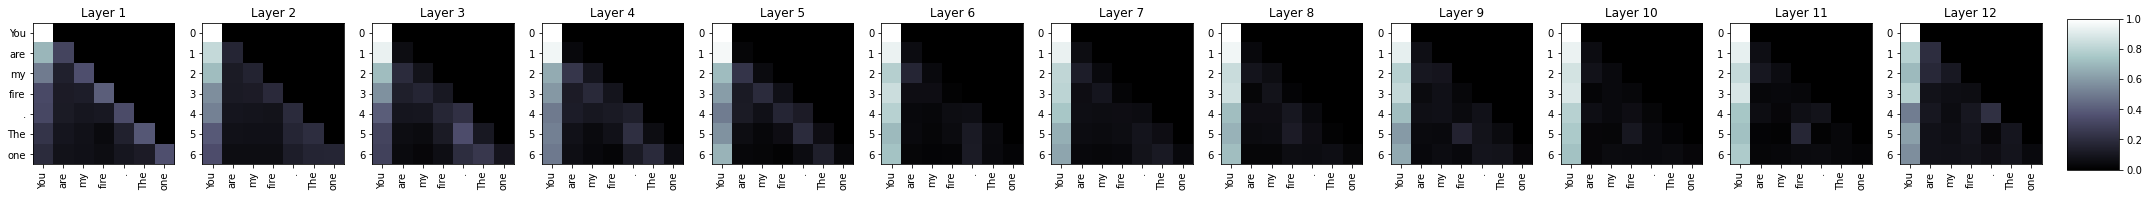

9953it [08:02, 20.61it/s]



  Average training loss: 2.62
  Training epoch took: 0:08:03

Running Validation...
  Validation Loss: 2.54
  Validation took: 0:00:09


3it [00:00, 24.48it/s]


======== Epoch 3 / 21 ========
Training...


3199it [02:33, 21.41it/s]

  Step 3,200  of  9,953. Loss: 2.034853219985962.   Elapsed: 0:02:33.
>'s your fault (or you got it wrong). And you're right (or you gotta find a way forward) and I am glad you got it right. Just don't think you can see (in the distance). You need to take to the skies. It's your fault. It's your fault (or you got it right). Just don't think you can see (in the distance).

I was born a man but I still feel that I was born in the wrong place (in the wrong place). Well just tell me why and I'll say it's your fault. Just don't think you can see (in the distance). You need to take to the skies. It's your fault. Just don't think you can see (in the distance). You need to take to the skies. Just don't think you can see (in the distance). You need to take to the skies. Just don't think you can see (
 who -> 0.47805336117744446
 I -> 0.21336033940315247
 that -> 0.20105531811714172
 you -> 0.06490068137645721
 thing -> 0.011070461943745613
 with -> 0.010446654632687569
 and -> 0.006480143871158

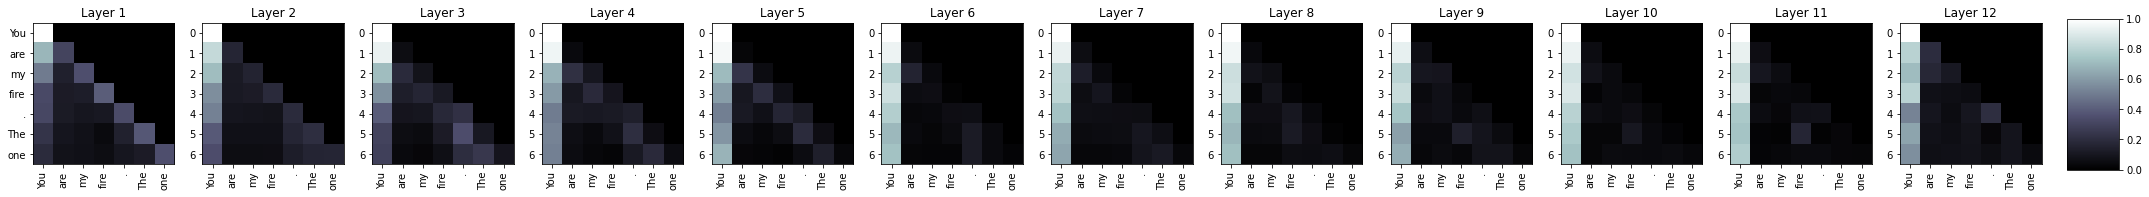

6400it [05:08, 22.33it/s]

  Step 6,400  of  9,953. Loss: 2.7176036834716797.   Elapsed: 0:05:09.
>kin (1958). The novel of Charles Acker, which was in the top ten of the best selling novelists lists in 1962. I mean, I am a lover of books. And I read Charles Acker. And I am a lover of books. And I'm not too scared to tell you where you fall. I'm a lover of books. And I read Charles Acker. And I'm a lover of books. And I'm not too scared to tell you where you fall. It's my boy, the novel of Charles Acker . You're the father I want you to keep away. You're the father I want your money to keep away. You're the father I want you to keep away. I need my home. It's my boy, the novel of Charles Acker . You're the father I want you to keep away.<|endoftext|> 20. The Lord of the Rings: The Return of
 who -> 0.4869327247142792
 I -> 0.22327277064323425
 that -> 0.19530440866947174
 you -> 0.05884762853384018
 with -> 0.010350516065955162
 and -> 0.006494507193565369
 thing -> 0.005880339071154594
. -> 0.004654429387301207

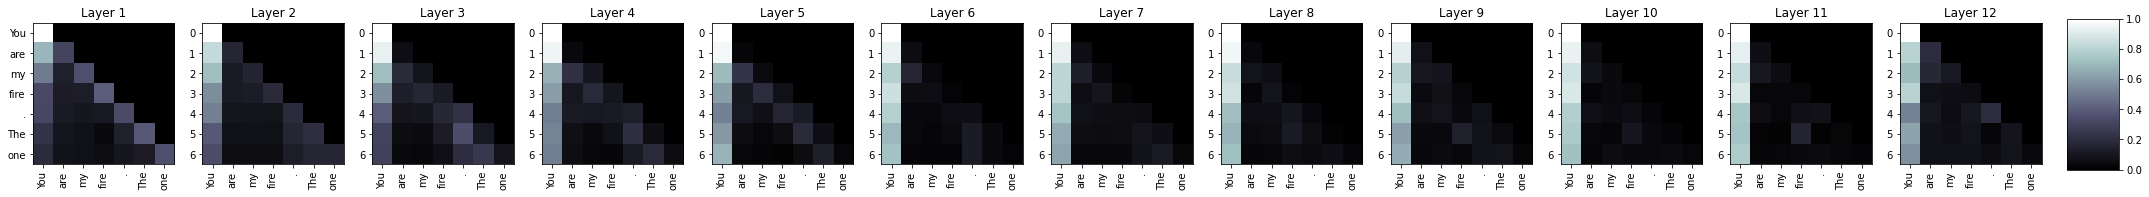

9599it [07:46, 21.81it/s]

  Step 9,600  of  9,953. Loss: 2.9505486488342285.   Elapsed: 0:07:46.
>-1834, my mind turned to politics. The war rages on, the American people's hearts turn to ashes. Never to be seen again! In the streets of Baghdad. At the end of the day, those who fought, those who betrayed are still there. The American people's heart goes to hell.. The American people's heart goes to hell.. The American people's heart goes to hell.. If you were to listen to those who died, you'd see the same feeling. A hundred years ago America was the only nation that held up high against the enemy. With a military force of 5 million men, there was never a time when America was better off. They saw this as a symbol of the American nation. This time was different. They saw this as a symbol of the American nation.<|endoftext|>

<|endoftext|>

<|endoftext|>

<|end
 who -> 0.564528226852417
 that -> 0.1869858056306839
 I -> 0.15753234922885895
 you -> 0.0565594919025898
 with -> 0.009701764211058617
 and -> 0.007995

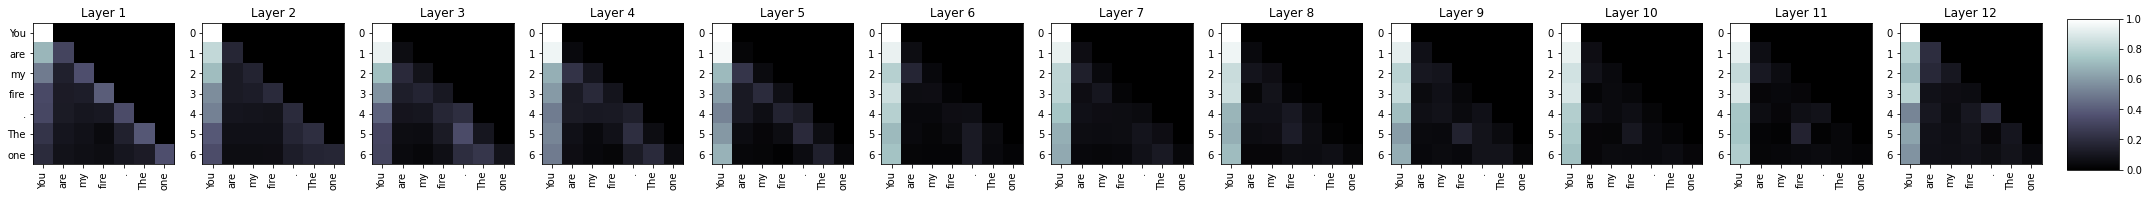

9953it [08:05, 20.48it/s]



  Average training loss: 2.59
  Training epoch took: 0:08:06

Running Validation...
  Validation Loss: 2.52
  Validation took: 0:00:09


3it [00:00, 21.16it/s]


======== Epoch 4 / 21 ========
Training...


3198it [02:33, 21.07it/s]

  Step 3,200  of  9,953. Loss: 3.295626163482666.   Elapsed: 0:02:33.
> so sorry. I'm so sorry. I'm so sorry. Are you feeling lonely?<|endoftext|>

[20:47] <Stuck> I've been feeling lonely for some time now.<|endoftext|>


<|endoftext|>


<|endoftext|>


<|endoftext|>


<|endoftext|>


<|endoftext|>


<|endoftext|>


<|endoftext|>


<|endoftext|></endoftext>


<|endoftext|><|endoftext|></text><|endoftext|></endoftext><|endoftext|></endoftext><|endoftext|><|endoftext|></endoftext><
 who -> 0.5086982250213623
 that -> 0.20850668847560883
 I -> 0.18771874904632568
 you -> 0.059376925230026245
 with -> 0.00896512158215046
 thing -> 0.007000873330980539
 and -> 0.006628748960793018
 in -> 0.0046614171005785465
 to -> 0.004267452284693718
. -> 0.004175758454948664


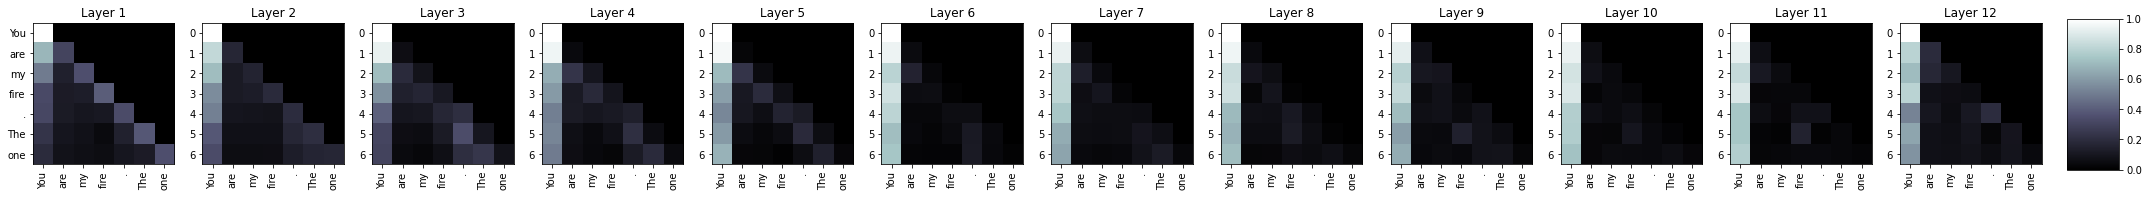

6399it [05:09, 20.15it/s]

  Step 6,400  of  9,953. Loss: 3.3419687747955322.   Elapsed: 0:05:10.
> of the story. If the day are always the same. And for that alone. You stand up with the grace of the light. And I'll be here. Forever. You're a part of the story. If the day are always the same. And for that alone. You stand up with the grace of the light. And I'll be here. Forever. You're a part of the story. For that alone. You stand up with the grace of the light. And I'll be here. Forever. You're a part of the story. For that alone. You stand up with the grace of the light. And I'll be here. Forever<|endoftext|>

<|endoftext|>

<|endoftext|>

<|endoftext|>

<|endoftext|>

<|endoftext|>

<|endoftext
 who -> 0.44321921467781067
 that -> 0.23442058265209198
 I -> 0.20369143784046173
 you -> 0.08034634590148926
 with -> 0.010870791971683502
 and -> 0.006308643613010645
 in -> 0.006296429317444563
 thing -> 0.005753339268267155
 of -> 0.004721388220787048
 to -> 0.00437183678150177


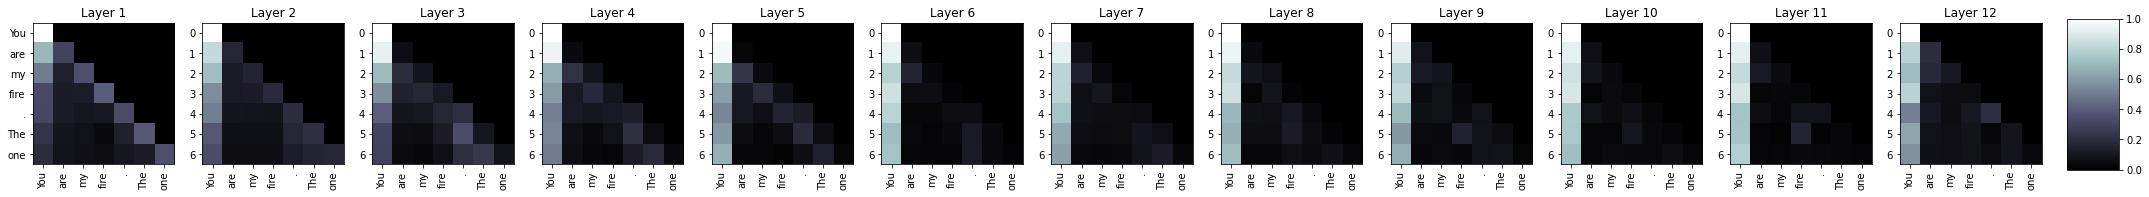

9599it [07:46, 23.01it/s]

  Step 9,600  of  9,953. Loss: 1.4327081441879272.   Elapsed: 0:07:47.
> do. Every day we come together. They can go back to the road I gave them in childhood the promise. So we can carry on until it's time for us to come together. When we're all standing around the same. Watching our leader down. We can all go, or we can go fast. Just take your hands off the reins. They can go back to the road I gave them in childhood the promise. So we can carry on until it's time for us to come together. When they're all holding hands. They can go back to the road I gave them in childhood the promise. So we can carry on until it's time for us to come together. They can go back to the road I gave them in childhood the promise. So we can carry on until it's time for us to come together<|endoftext|>

"Don't lose hope. Look up. Do my work. They can go
 who -> 0.4315694570541382
 that -> 0.23091614246368408
 I -> 0.22868256270885468
 you -> 0.07288974523544312
 with -> 0.009310616180300713
 thing -> 0.00

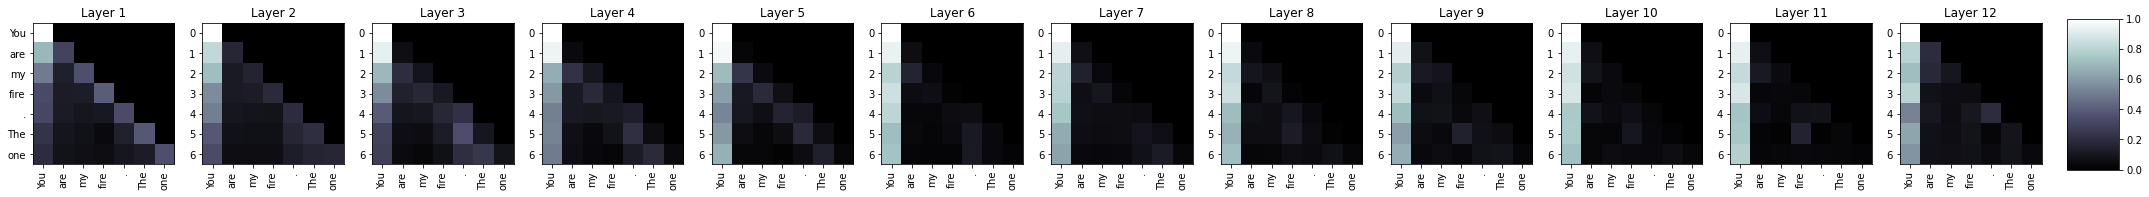

9953it [08:06, 20.47it/s]



  Average training loss: 2.57
  Training epoch took: 0:08:06

Running Validation...
  Validation Loss: 2.51
  Validation took: 0:00:09


3it [00:00, 27.54it/s]


======== Epoch 5 / 21 ========
Training...


3198it [02:33, 20.36it/s]

  Step 3,200  of  9,953. Loss: 3.1964805126190186.   Elapsed: 0:02:33.
> know that you're just as lonely. So how could you be so lonely?. So how could you be lonely?. I told you that you were lonely. I had promised you that. When I felt you so weak. I told you that you were alone. You're so weak. Why are you so lonely?. Why are you so lonely?. Why are you so lonely?. Why are you so lonely?. Why are you so lonely?. Why are you so lonely?. Why are you so lonely?. Why are you so lonely<|endoftext|><|endoftext|>

RAW Paste Data

<|endoftext|> <|endoftext|> <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|
 who -> 0.4372731149196625
 that -> 0.24682921171188354
 I -> 0.21152889728546143
 you -> 0.06464914977550507
 with -> 0.008940069004893303
 thing -> 0.008692357689142227
 and -> 0.008178371004760265
 in -> 0.00530798127874732
 to -> 0.004787976387888193
 of -> 0.003812941489741206


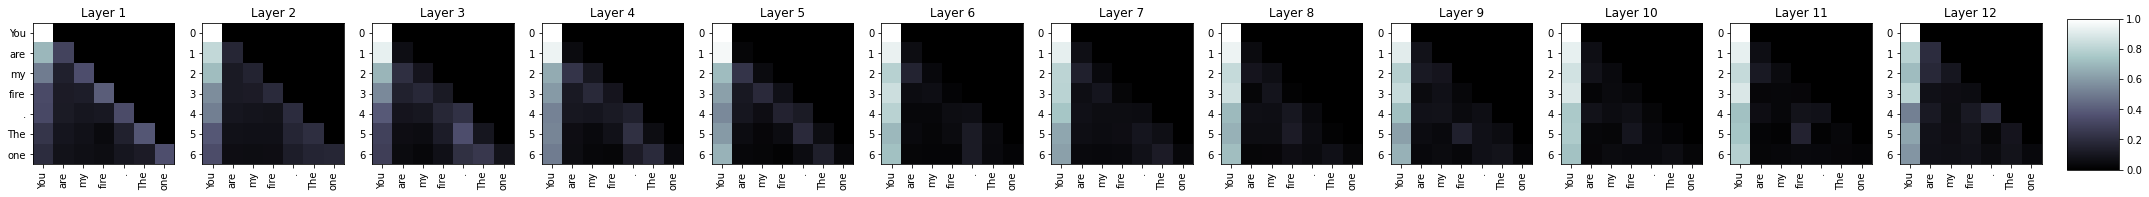

6399it [05:10, 21.19it/s]

  Step 6,400  of  9,953. Loss: 1.3533371686935425.   Elapsed: 0:05:11.
> no. I should have said no,. And not. And this way I should have done it. And now I should have said no. Why should I have said no,. Why should I have done it. And now I should have done it. But I was wrong then,. Why should I have said no. Then let me say it. Now I should have said no. Why shouldn I have done it. And now I should have done it, and I should have done it. And now I should have done it. But I was wrong then,. Why should I have said no. So let me say it. Now I should have done it. And now I should have done it. And now I should have done it. But I was wrong then,. I should have just left it at home. Then let me say it. Now I could have done it. But I'm wrong now,. Why should I should have done it<|end
 who -> 0.47572454810142517
 that -> 0.22711212933063507
 I -> 0.19443278014659882
 you -> 0.06583421677350998
 with -> 0.008796758949756622
 and -> 0.007856478914618492
 thing -> 0.007852045819163322
 i

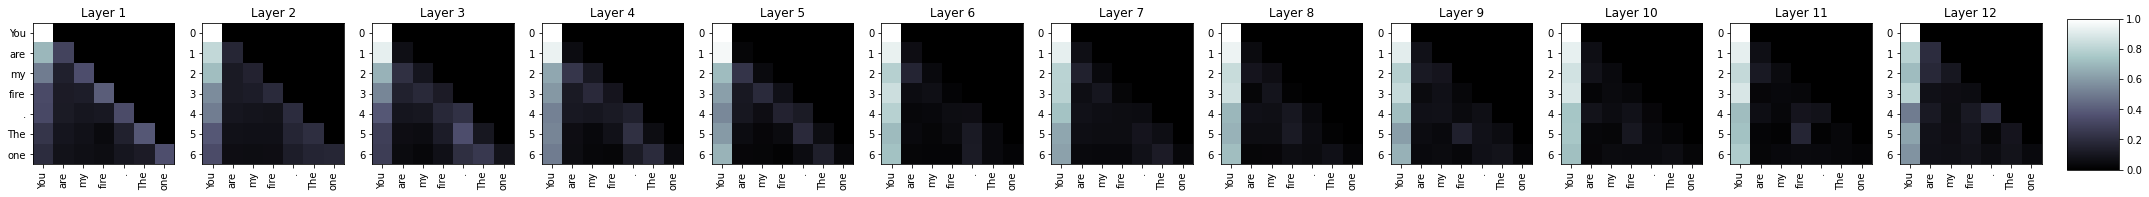

9598it [07:45, 21.47it/s]

  Step 9,600  of  9,953. Loss: 2.595121383666992.   Elapsed: 0:07:46.
> C. J.). A man must be a friend of all. A man must be a friend of all. A good man must be a friend of all. A good man can be a friend of all. If a good man is a friend of all, then he can be a friend of all. If a good man is a friend of all, then he can be a friend of all. A good man can be a friend of all. A good man can be a friend of all. If your friend is a friend of all! A good man can be a friend of all. A good man can be a friend of all<|endoftext|>||<|endoftext|>|>|<|endoftext|>|<|endoftext|>|<|endoftext|>|<|endoftext|>|<|endoftext|>|<<endoftext|>
 who -> 0.47154974937438965
 that -> 0.22207917273044586
 I -> 0.1996743381023407
 you -> 0.07451613247394562
 with -> 0.00766358245164156
 and -> 0.006562015041708946
 thing -> 0.00646545784547925
 in -> 0.004954365082085133
 to -> 0.0037479486782103777
 of -> 0.002787258243188262


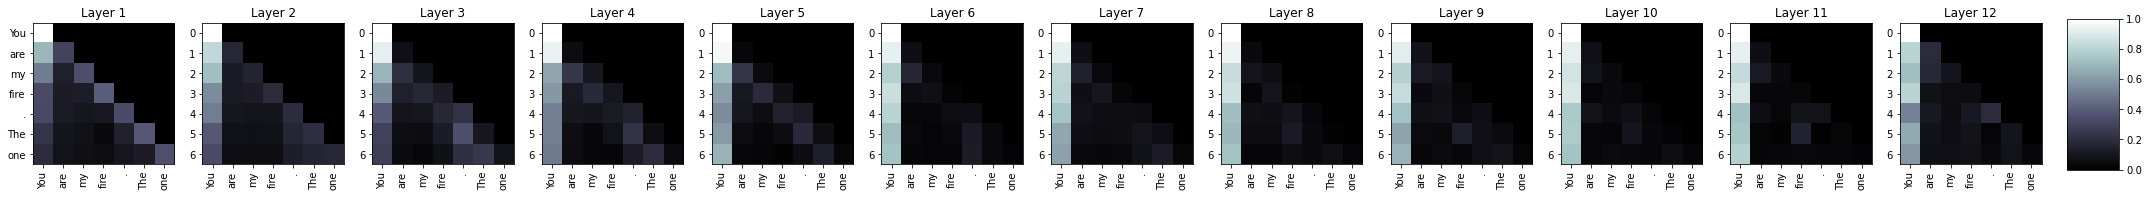

9953it [08:05, 20.50it/s]



  Average training loss: 2.55
  Training epoch took: 0:08:06

Running Validation...
  Validation Loss: 2.50
  Validation took: 0:00:09


3it [00:00, 25.02it/s]


======== Epoch 6 / 21 ========
Training...


3199it [02:33, 19.98it/s]

  Step 3,200  of  9,953. Loss: 1.8036807775497437.   Elapsed: 0:02:33.
> There are better people than you. Now I know who you are. And now I know who you are. And now I know who you are. We're the world's people. But we're people here. We're the world's people. But we're people here. We're the world's people. But we're people here. We're the world's people. But we're people here. We're the world's people. But we're people here. We're the world's people. But we're people here. We're the world's people. But we're people here<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|
 who -> 0.5148541927337646
 that -> 0.199788436293602
 I -> 0.1893753856420517
 you -> 0.06630226224660873
 with -> 0.007620255928486586
 and -> 0.005496207624673843
 thing -> 0.0047699809074401855
 in -> 0.004395586438477039
 to -> 0.004390994552522898
. -> 0.0030067600309848785


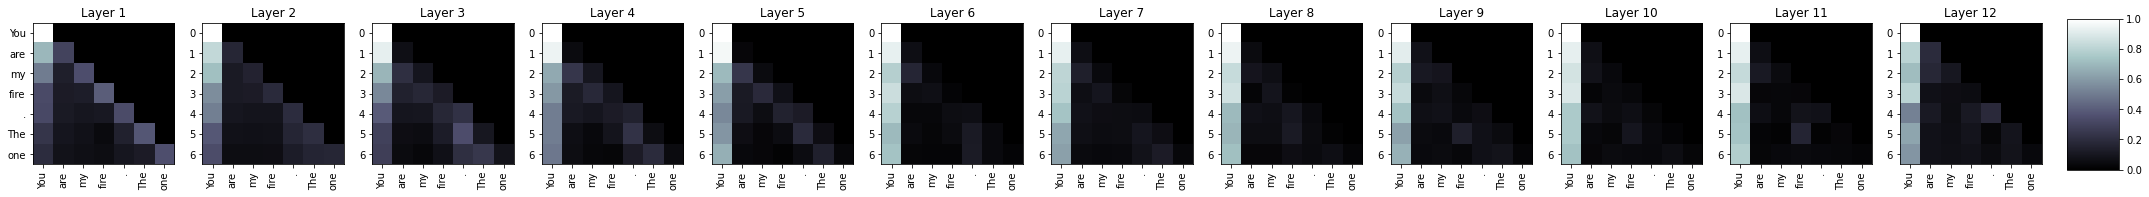

6399it [05:09, 20.95it/s]

  Step 6,400  of  9,953. Loss: 2.6233785152435303.   Elapsed: 0:05:09.
> And we did what we used to do. To look in, to talk, to pray. And we talked a lot too. As they came off this cliff. And they stayed and talked. They tried to take over. So some thought, some thought. That we might as well try. Let's play the game. It's got all the best parts. And that's what we tried. Got to have fun. Cause it's got all the best parts. And that's what we tried. Got to have fun. No, no. You're going to be disappointed. There's a lot to it. A lot to do. You may be right, but, there's something about that. And that's all I can say. Is that what we said. If I gave away my soul. I got to have fun. Cause it's got all the best parts. And that's what we tried. Got to have fun. Cause it
 who -> 0.5276620984077454
 that -> 0.2045367956161499
 I -> 0.17671768367290497
 you -> 0.06011920049786568
 with -> 0.009837728925049305
 in -> 0.005305275321006775
 and -> 0.0048998817801475525
 thing -> 0.004575736820697

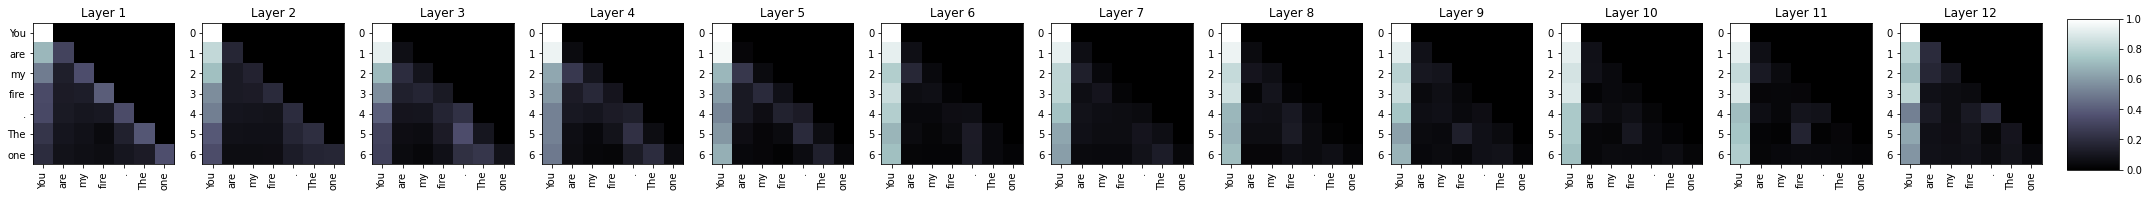

9600it [07:44, 22.30it/s]

  Step 9,600  of  9,953. Loss: 2.827474355697632.   Elapsed: 0:07:45.
>, that I could never live to be as beautiful as I am. If I could ever be as beautiful as ever I would be. And now I must keep this up and be good. I remember my days in the dark, and your footsteps. A little boy I might want to meet. He's got a bad boy. I'm sorry I have to say tonight I hope you will forgive me tonight I hope you will forgive me tonight I hope you will forgive me tonight. I've been so bad at sleeping my way out with you the last night I remember. You took my life, you made me cry. Yes I have taken your life, I've taken your life. And now I must keep this up and be good. I remember my days in the dark, and your footsteps. A little boy I might want to meet<|endoftext|><|endoftext|> <|endoftext|><|end
 who -> 0.5139350295066833
 that -> 0.23050449788570404
 I -> 0.16430985927581787
 you -> 0.059168197214603424
 with -> 0.010740036144852638
 in -> 0.00603473512455821
 and -> 0.004581921733915806
. -> 0.

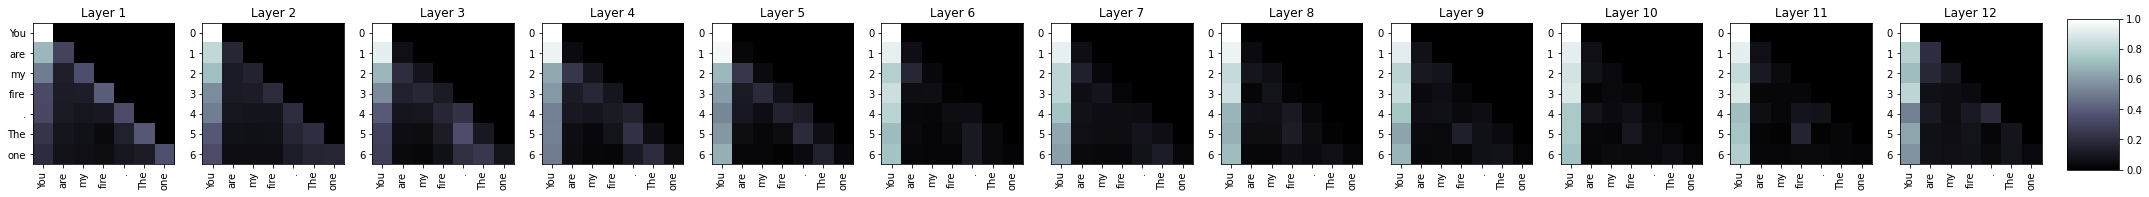

9953it [08:04, 20.56it/s]



  Average training loss: 2.54
  Training epoch took: 0:08:04

Running Validation...
  Validation Loss: 2.49
  Validation took: 0:00:09


3it [00:00, 21.50it/s]


======== Epoch 7 / 21 ========
Training...


3198it [02:32, 21.61it/s]

  Step 3,200  of  9,953. Loss: 0.9256982803344727.   Elapsed: 0:02:33.
>.00.00: I saw your lips go wide and your nose go dry. You came and you left. I said, you should be in a hurry. I felt you move and I said,. you're a fool. I said, you're a fool. I told you I can't tell you the truth. You'd be a fool if you got a smile. No, my baby, we're not foolin'. All we're foolin'. Look at us and you look at the wall. They're coming for you. Come on down the street and they come for you<|endoftext|>.<|endoftext|>.<|endoftext|><|endoftext|>.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><
 who -> 0.49600738286972046
 that -> 0.23211775720119476
 I -> 0.1800563633441925
 you -> 0.056915026158094406
 with -> 0.00936763733625412
 and -> 0.005559168290346861
 thing -> 0.005556497257202864
. -> 0.0052403961308300495
 in -> 0.004694558214396238
 to -> 0.004485324490815401


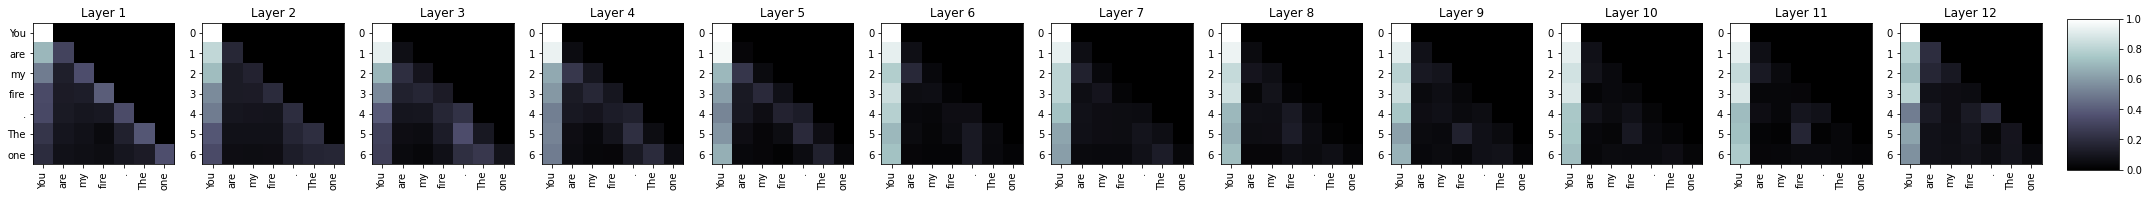

6399it [05:08, 21.36it/s]

  Step 6,400  of  9,953. Loss: 1.8556842803955078.   Elapsed: 0:05:09.
>. And tell her that she needs to get her thoughts away. From her, the girl. That's right,. She needs her mind in control. And let the child of night ride to the beat. She's gonna blow her mind,. Get on your roll,. And make her go down. I'm gonna leave you feeling the same,. Now just let her ride, keep pushing, keep going, keep up. Get on your roll,. And make her go down. I'm gonna leave you feeling the same,. Now just let her ride,. Keep pushing, keep going, keep up. Give it all back, don't let her pull you down. Give it all back, give it all back,. Give it all back, give it all back,. Give it all back, give it all back,. Give it all back, give it all back,. Give it all back, give it all back,. Give it all back, give it all back,. give
 who -> 0.4815646708011627
 that -> 0.24677114188671112
 I -> 0.16928386688232422
 you -> 0.06357462704181671
 thing -> 0.008748320862650871
 with -> 0.008062713779509068
 and -> 0.0

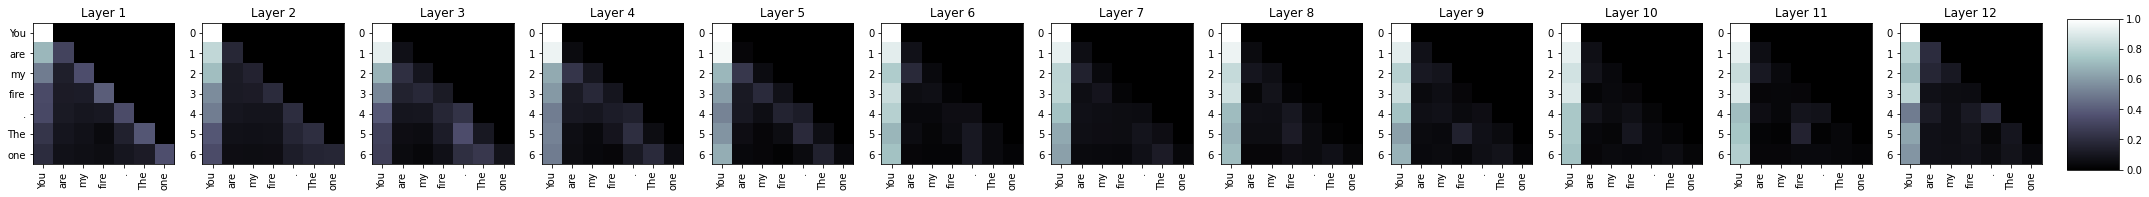

9600it [07:44, 19.37it/s]

  Step 9,600  of  9,953. Loss: 1.776515007019043.   Elapsed: 0:07:45.
> a freak of nature. That wasn't right. I'd never heard that old tune. My heart beat a whole lot faster. If anything, I lived in that state. I'm alive, and I'm free. I'm free. I'm free. If anything, I lived in that state. I'm alive, and I'm free. If anything, I lived in that state. I'm alive, and I'm free. If anything, I lived in that state. If anything, I didn't really like. If anything, I wasn't sure. If anything, I was a freak of nature. That didn't go down well. If anything, I was a freak of nature. That didn't go down well. If anything, I wasn't sure. I was too young. I ain't nothing. Just plain old tired. If anything, I spent most of my time in the dark. I'm alive and I'm free.
 who -> 0.44643765687942505
 that -> 0.263158917427063
 I -> 0.19494639337062836
 you -> 0.06284810602664948
 with -> 0.007353825028985739
 and -> 0.007003484293818474
 thing -> 0.0060221534222364426
 in -> 0.005131291691213846
. -> 0.00

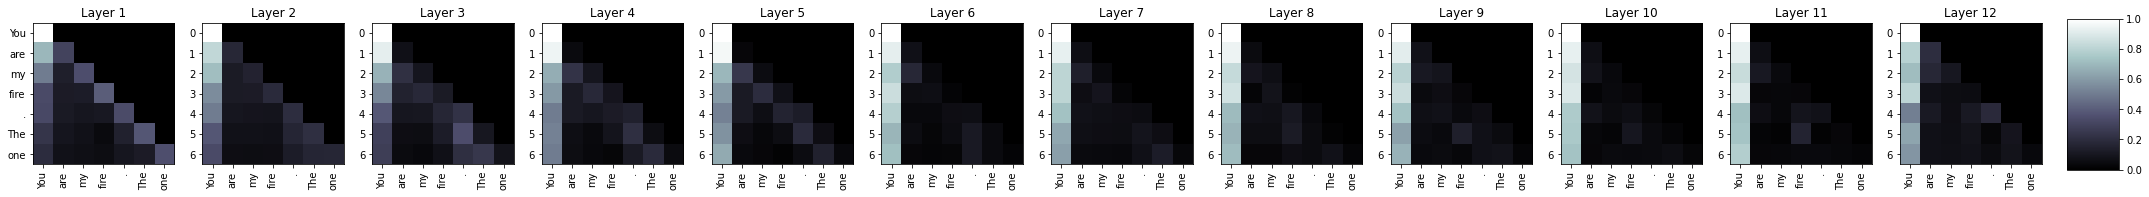

9953it [08:04, 20.55it/s]



  Average training loss: 2.53
  Training epoch took: 0:08:04

Running Validation...
  Validation Loss: 2.49
  Validation took: 0:00:09


3it [00:00, 19.58it/s]


======== Epoch 8 / 21 ========
Training...


3200it [02:34, 21.07it/s]

  Step 3,200  of  9,953. Loss: 2.256303310394287.   Elapsed: 0:02:34.
>. We decided to move, so that it could be more. We planned to move, move, move, move.. We were so naive. We had no idea. We were so naive. We had no idea. We were so naive.. And if you're going to do it, I know it's time you tried. It's time you tried. And if you're not going to do it.. You're doing what you said you'd do. You're doing what you said you'd done. That's why you got me. You got me, yeah. You're doing what you say you'd do. But if you're going to do it, I know it's time you tried.. You're doing what you said you'd do. You're doing what you say you'd done. That's why you got me, I don't know, but it's time. You're doing what you said you'd do. You're doing
 who -> 0.44272270798683167
 that -> 0.28473755717277527
 I -> 0.17499929666519165
 you -> 0.06478414684534073
 with -> 0.0075419992208480835
 and -> 0.0069907656870782375
 in -> 0.005306337494403124
 thing -> 0.00465053366497159
. -> 0.004303010180592

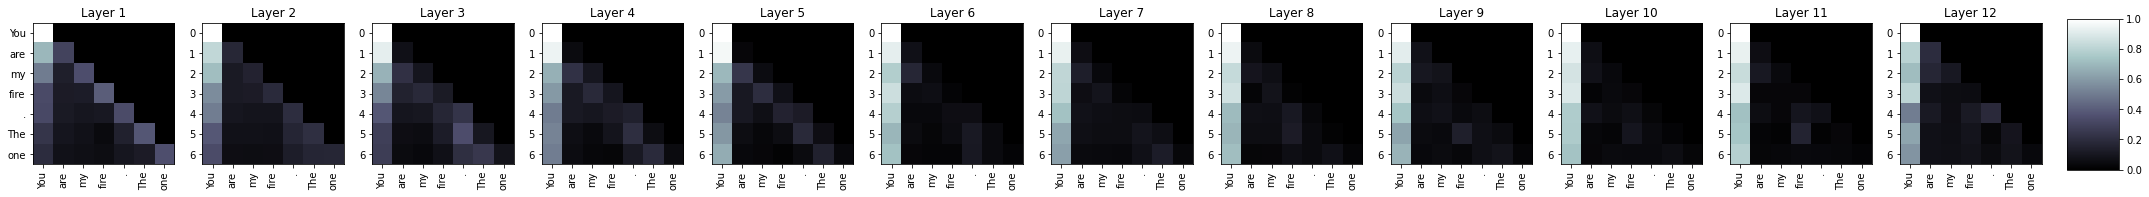

6398it [05:08, 20.04it/s]

  Step 6,400  of  9,953. Loss: 2.593278169631958.   Elapsed: 0:05:08.
>. Like a real rock 'n' roll gang, which is a song about that, love of rock 'n' roll gang. When you think that rock 'n' roll gang was gone, go out with your hands full. Rock 'n' roll gang, you were never too shy, you were too smart, you could see the future. Well, I know no more, but it seems like it was. Just some days, I'm feeling lost. What was it that I hoped was gone, then. But it is still there, still there, just gone. I could never say something more true. I'm not satisfied with it now, but it is still there. I'd like to, but it would be better for someone else. Rock 'n' roll gang, go out and find out. Hey, hey, go on down the street. Rock 'n' roll gang, you were never too shy we were just there
 who -> 0.43544378876686096
 that -> 0.27645567059516907
 I -> 0.18281251192092896
 you -> 0.06484749913215637
 with -> 0.009536024183034897
 and -> 0.009324437007308006
 in -> 0.006443492602556944
. -> 0.0053129042498

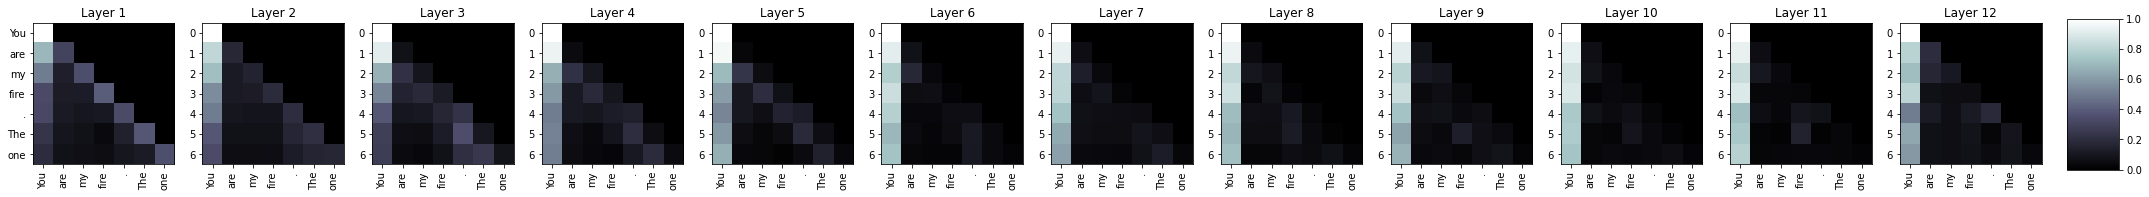

9600it [07:45, 17.64it/s]

  Step 9,600  of  9,953. Loss: 2.5496785640716553.   Elapsed: 0:07:45.
>. For I know that you, are my most precious treasure. This has been my true love. Oh, oh, oh, oh ... and I know I love you. And I know that you're my only friend. And I know that you're my only friend. But I'm so sorry that you thought this way. But I'm so sorry that you thought this way. Why can't you find a way out of this darkness. Where life can be no more than you desire. Oh, oh, oh, oh ... oh, oh. Oh, oh, oh, oh. Oh, oh, oh, oh ... oh, oh, oh, oh. Oh, oh, oh, oh. Oh, oh, oh, oh. Oh, oh, oh, oh. Oh, oh, oh, oh. Oh, oh, oh, oh. Oh, oh, oh, oh. Oh, oh, oh, oh. Oh
 who -> 0.3874857425689697
 that -> 0.29136037826538086
 I -> 0.2082163393497467
 you -> 0.07096158713102341
 with -> 0.010558447800576687
 and -> 0.009182581678032875
 thing -> 0.007324736099690199
 in -> 0.006055348087102175
. -> 0.005067428573966026
 of -> 0.003787403227761388


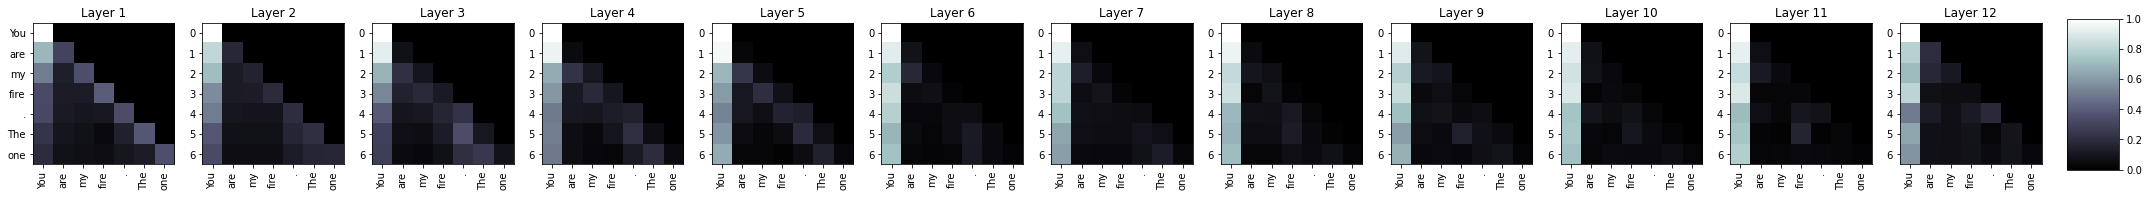

9953it [08:04, 20.53it/s]



  Average training loss: 2.52
  Training epoch took: 0:08:05

Running Validation...
  Validation Loss: 2.49
  Validation took: 0:00:09


3it [00:00, 22.66it/s]


======== Epoch 9 / 21 ========
Training...


3199it [02:33, 20.78it/s]

  Step 3,200  of  9,953. Loss: 4.727306365966797.   Elapsed: 0:02:33.
> show you. You are free of this curse. And I will tell you how the world is. The way it is when you do not look. If you do not want to believe. Then I will show you how it is. You shall be free from it. Then I will show you how the world is. What I have seen. What I have heard. I have seen. I have listened. Why would your hearts be so low. Would you be free from this curse..? It is the curse of this world. I have seen. I have heard. I have heard. I have listened. Why would your hearts be so low. Would you be free from this curse.<|endoftext|> Oww!. Well, I know I haven't seen this before. I don't know how I will show you now.<|endoftext|> And I will show you how it is. You shall be free from it.
 who -> 0.39989739656448364
 that -> 0.3081033527851105
 I -> 0.19598740339279175
 you -> 0.06157379224896431
 with -> 0.009308388456702232
 and -> 0.006673858501017094
 in -> 0.005189047660678625
 to -> 0.004929712507873774

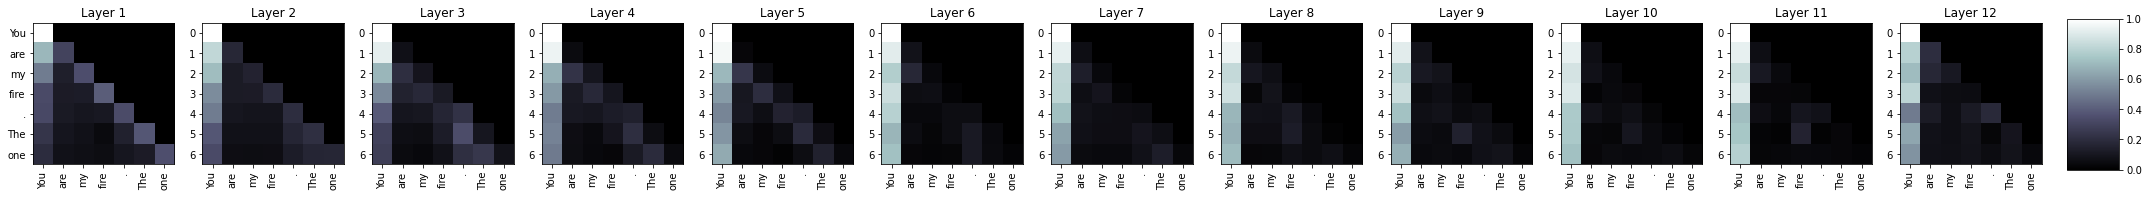

6400it [05:09, 17.35it/s]

  Step 6,400  of  9,953. Loss: 1.8488978147506714.   Elapsed: 0:05:09.
> in central Asia. (2 pictures). Now I have to go to Moscow, where the Russian army is in full action. A day I was not too far away, and it is the first time I see Russian soldiers. They say that they were sent to the front, to fight for the Russian cause. But before they could do anything, I heard their engines turn. And the men around are shouting, "Don't be like them!". Don't let them get out of control. Now I have to go to Moscow, where the Russian army was in full action. In the city of Kibas, in central Asia. (2 pictures). Now I have to go to Moscow, where the Russian army is in full action. Now I have to go to Moscow, where the Russian army is in full action. Now I have to go to Moscow, where the Russian army was in full action. Now I have to go to Moscow, where the
 who -> 0.4034237563610077
 that -> 0.3153418302536011
 I -> 0.18550582230091095
 you -> 0.06201069429516792
 with -> 0.009559987112879753
 in ->

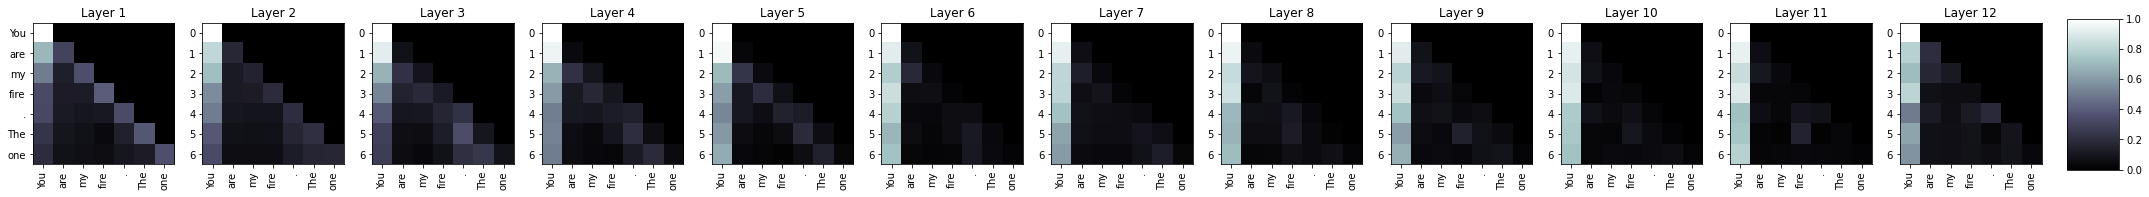

9600it [07:45, 22.72it/s]

  Step 9,600  of  9,953. Loss: 1.9388067722320557.   Elapsed: 0:07:45.
> And she is not just a darling, she knows what's a pleasure. To be your favorite sister. You can make your sisters happy. But when it comes to love, you need to get her. And she's not just a darling, she knows what's a pleasure. In love is not blissful, it's a happy one. In love is something more than just a love song. To make it a true pleasure. But she can't forget her love. And it's not just a pleasure. To be your favorite sister. You can make your sisters happy. But when it comes to love, you need to get her. And she's not just a darling, she knows what's a pleasure. To be your favorite sister.<|endoftext|><|endoftext|>It's good to be around the moon. But I don't think I'd be able to feel it. And I'm afraid that this time I'm going to have to
 who -> 0.39737340807914734
 that -> 0.3156844973564148
 I -> 0.19700245559215546
 you -> 0.0612790584564209
 with -> 0.008760454133152962
 in -> 0.0057381936348974705
 th

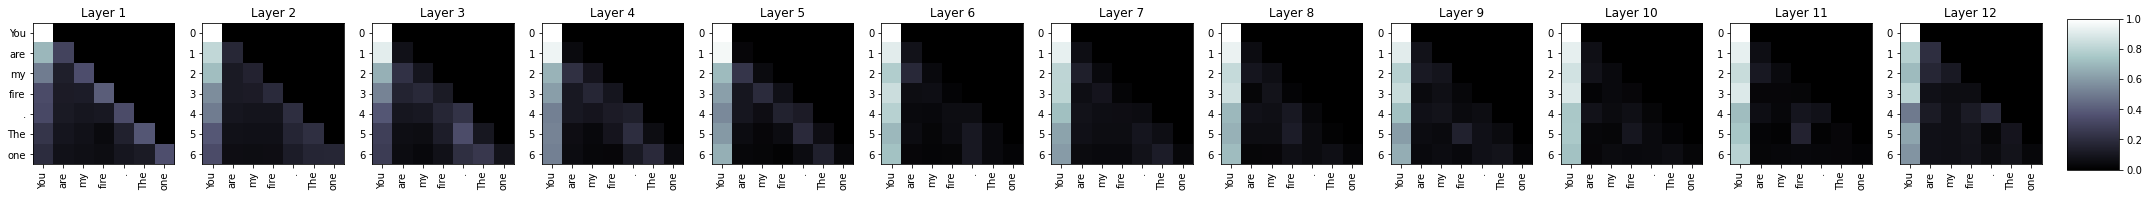

9953it [08:04, 20.53it/s]



  Average training loss: 2.52
  Training epoch took: 0:08:05

Running Validation...
  Validation Loss: 2.48
  Validation took: 0:00:09


2it [00:00, 17.90it/s]


======== Epoch 10 / 21 ========
Training...


3199it [02:32, 21.84it/s]

  Step 3,200  of  9,953. Loss: 1.7607994079589844.   Elapsed: 0:02:33.
> place is your heart that I was born to care. All the things that I've done I can't do. And there's something else about my life I wish I could find. The one you love. Is the one you got. The one you love. The one you're all over. The one you love. The one you're all over. Something else inside you. Everything that I've done. I've won all the battles. And this is the one that I'll fight. Everything that I'm doing. I'm the one that I'm just going through. When you're alone. Feeling the same, feeling your way. The one you love. Is the one you got. The one you love. The one you're all over. The one you're in. The one you're in<|endoftext|><|endoftext|>

<|endoftext|>

<|end
 that -> 0.3369806408882141
 who -> 0.3325367271900177
 I -> 0.2250279188156128
 you -> 0.07034778594970703
 with -> 0.010378931649029255
 in -> 0.006385353393852711
. -> 0.005003019701689482
 thing -> 0.004806844051927328
 and -> 0.004790844395756

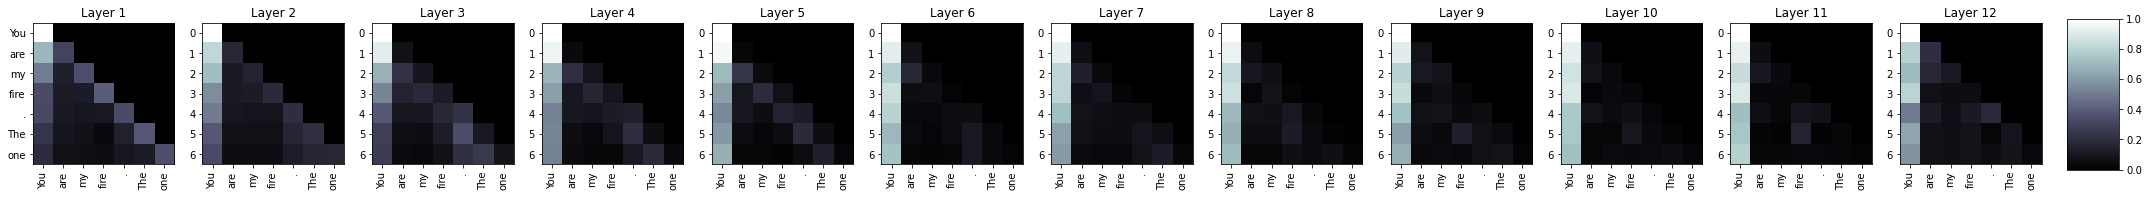

6399it [05:09, 21.01it/s]

  Step 6,400  of  9,953. Loss: 3.852958917617798.   Elapsed: 0:05:10.
> where you are. The place you've been for a couple of years. Like when you'd walk the streets of my city. I'm here to tell you and tell you the story. There's a place in my heart where I love you and share the love. There's a place in my heart that I want to take. I keep on trying to find you. But I find you far away and leave no answer. I know when you walk into your dreams. You'd be gone but I have no one else. To remind me of your love. You'll stay forever. You'll never forget me. You're a beautiful angel. I don't want to know everything. I just want to see life. There's a place in my heart where I love you and share the love. There's a place in my heart that I want to take<|endoftext|><|endoftext|><|endoftext
 who -> 0.3642981946468353
 that -> 0.3157576620578766
 I -> 0.20822276175022125
 you -> 0.07719871401786804
 with -> 0.01077014859765768
 in -> 0.006106661632657051
 and -> 0.005786392372101545
. -> 0.0041

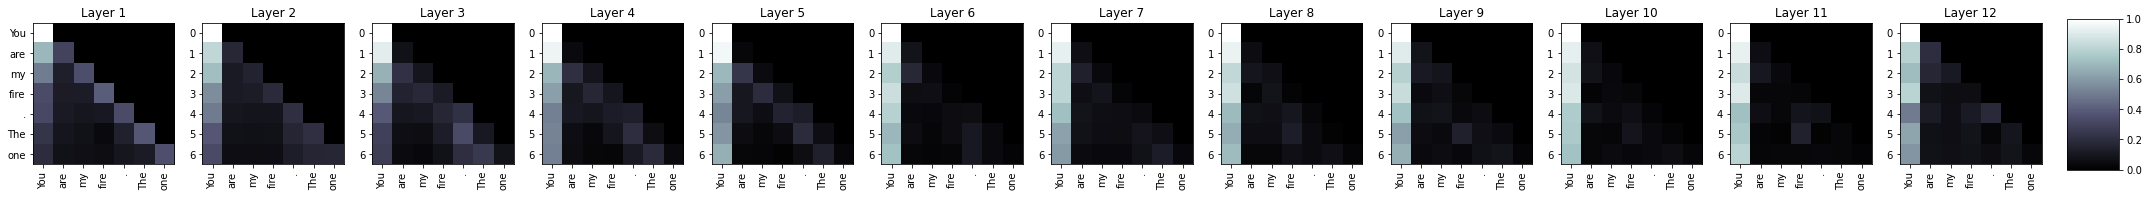

9599it [07:45, 21.08it/s]

  Step 9,600  of  9,953. Loss: 3.1543684005737305.   Elapsed: 0:07:46.
> love, it was. Love, love, love. The night that you walked down the hall. It's a beautiful night. The morning that it was gone. There's a golden child in the skies. With a golden smile. It's a golden child in the skies. There's a golden child in the skies. There's an evening when your eyes meet. There is a beautiful girl who keeps smiling. There is a beautiful girl who is smiling at that moment. There is an evening when your eyes meet. There is a beautiful girl who's smiling at that moment. There is an evening when your eyes meet. I've been waiting for you. The morning that my dreams were dashed. And there, there's a golden child in the skies. There is a golden child in the skies. There's a golden child in the skies. There's an evening when your eyes meet. There is a beautiful girl who keeps smiling. So it's a
 who -> 0.36540746688842773
 that -> 0.3269648849964142
 I -> 0.2048749476671219
 you -> 0.070870980620384

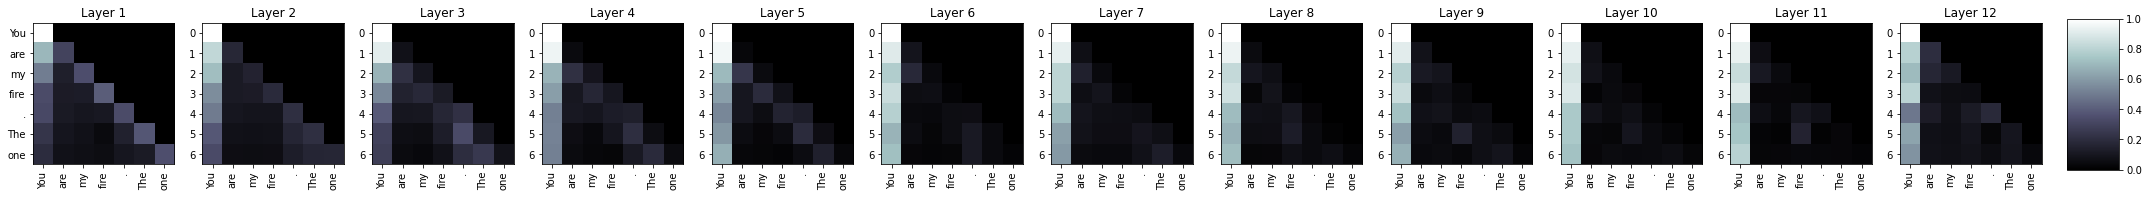

9953it [08:05, 20.52it/s]



  Average training loss: 2.51
  Training epoch took: 0:08:05

Running Validation...
  Validation Loss: 2.48
  Validation took: 0:00:09


2it [00:00, 19.79it/s]


======== Epoch 11 / 21 ========
Training...


3199it [02:32, 22.78it/s]

  Step 3,200  of  9,953. Loss: 1.6184725761413574.   Elapsed: 0:02:33.
>. "Baby you're such a boy. You're so charming". That's so funny, isn't it?. When she cries that she really loves. Me and I will sing a tune for ya. "Stairway to Heaven!". Baby, she's such a beautiful girl. You wanna make me dance with her.. Now what's wrong with you, you know. Baby, I can't bear to see you fall in love,. Baby, I know. I love you so much, baby, I love you so much.. I love you so much, baby, I just don't know what to do. I need you so much, baby, I just don't know what to do. I need you so much, baby, I just don't know what to do. Baby, I can't bear it.. But you know that I can't hide. I don't know what to say. I want to cry, baby, I
 that -> 0.3342231810092926
 who -> 0.33158934116363525
 I -> 0.22490786015987396
 you -> 0.07254823297262192
 with -> 0.010750637389719486
 and -> 0.006348776631057262
 thing -> 0.005897113587707281
 in -> 0.005522566381841898
. -> 0.004140979144722223
 to -> 0.00407130

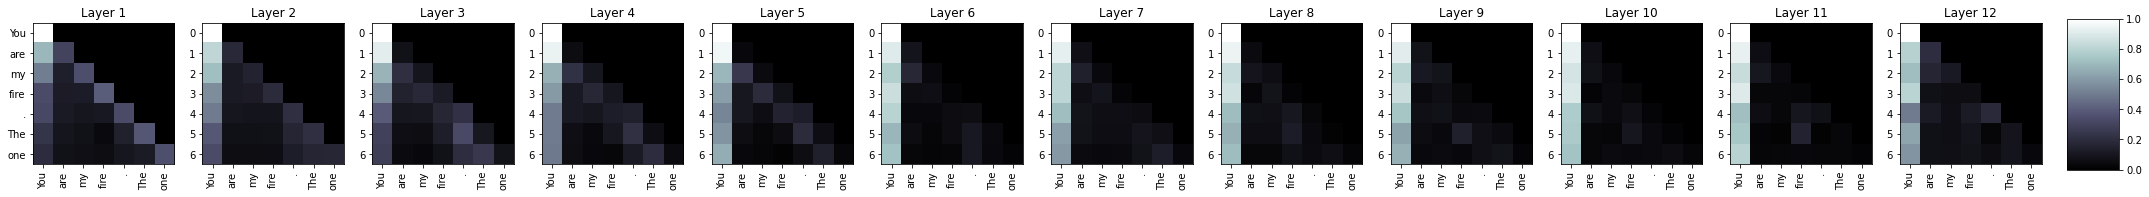

6400it [05:09, 20.07it/s]

  Step 6,400  of  9,953. Loss: 2.005810022354126.   Elapsed: 0:05:09.
> me, walk me back home. Take a moment to talk to you again. Take a moment to share my love. Take a moment to make friends. Take even a moment to talk to you. Take a moment to write a book. Take a moment to find a friend. Take a moment to meet someone else. Take a moment to say hello, get down on the ground. Take a moment to share my love, take a moment to meet someone else. Take even a moment to say hello. Take a moment to talk to you again. Take a moment to meet someone else. Take even a moment to say hello<|endoftext|> Take a moment to meet someone else. Take even a moment to say hello<|endoftext|> Take a day to be alone. No one else around has a clue.<|endoftext|> Take a day to be alone<|endoftext|> Take a day to
 that -> 0.32529035210609436
 who -> 0.3192640542984009
 I -> 0.23145870864391327
 you -> 0.08483570069074631
 with -> 0.01055277418345213
 thing -> 0.008348568342626095
 and -> 0.00694463774561882
 in -

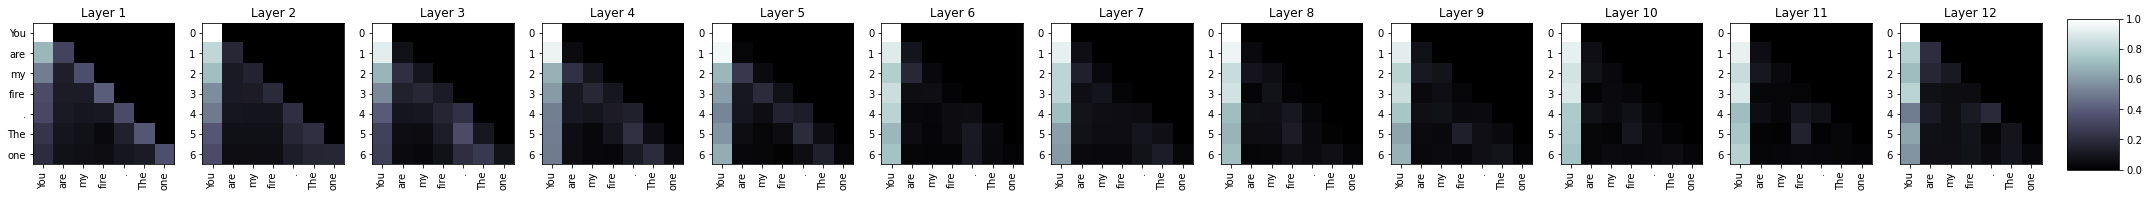

9599it [07:45, 21.37it/s]

  Step 9,600  of  9,953. Loss: 1.611405849456787.   Elapsed: 0:07:45.
> to lose, without a plan. I'm taking the fight to the devil by playing the game again. I take no chances when it comes to getting on with it. But I feel so far to the end I'm beginning to wonder. Why does my life go by the way. What is my feeling now?. The truth is you are the ones that give me the answers. I'm living my life for you today. And you've always been there for me today. I'm living my life for you today. I'll never forget the moment when I saw you at the end of the tunnel. Was sitting with my hand on my hip while you looked me in the eye. And you asked your head coach, what was the first thing that came to mind. When I told you that you were my friend, I was hoping to find out. Because you knew I could never stay as long as I do. And you were my friend. All
 that -> 0.3347339630126953
 who -> 0.33134952187538147
 I -> 0.20630386471748352
 you -> 0.08162429183721542
 thing -> 0.011206576600670815
 with ->

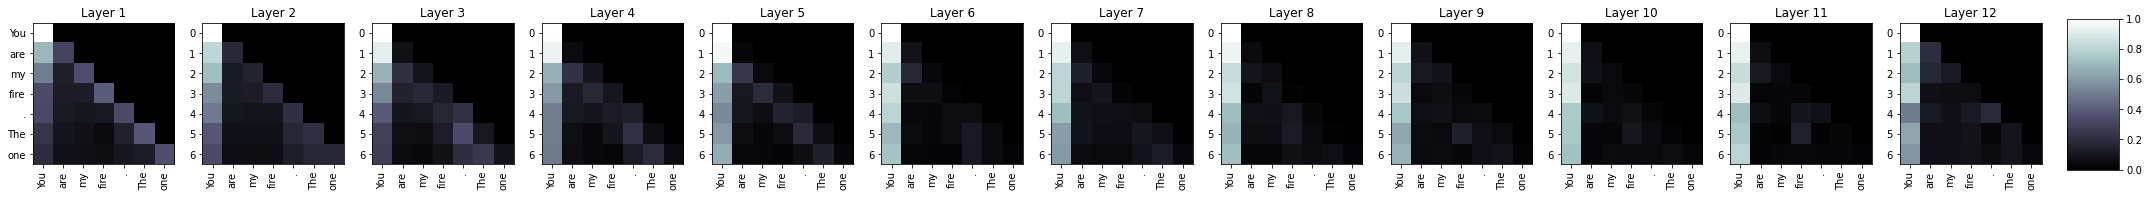

9953it [08:04, 20.54it/s]



  Average training loss: 2.51
  Training epoch took: 0:08:04

Running Validation...
  Validation Loss: 2.47
  Validation took: 0:00:09


3it [00:00, 21.06it/s]


======== Epoch 12 / 21 ========
Training...


3198it [02:31, 20.55it/s]

  Step 3,200  of  9,953. Loss: 3.625185012817383.   Elapsed: 0:02:32.
> a rainy night with the river running under me. I can hear the wind driving through the wind. I can hear the wind. It cuts through me like a broken tree. I've been standing up. The wind is blowing my way. I've been standing up. It cuts through me like a broken tree. It cuts through me like a broken tree. It cuts through me like a broken tree. Yeah it cuts through me like a broken tree. Yeah It cuts through me like a broken tree. Yeah It cuts through me like a broken tree. Yeah it cuts through me like a broken tree. Yeah it cuts through me like a broken tree. Yeah it cuts through me like a broken tree. Yeah it cuts through me like a broken tree. You know the last time I got a chance to make it home. Yeah it cuts through me like a broken tree. Yeah it cuts through me like a broken tree. Yeah it cuts through me like a
 that -> 0.3405642509460449
 who -> 0.3037487864494324
 I -> 0.22589576244354248
 you -> 0.08699893206

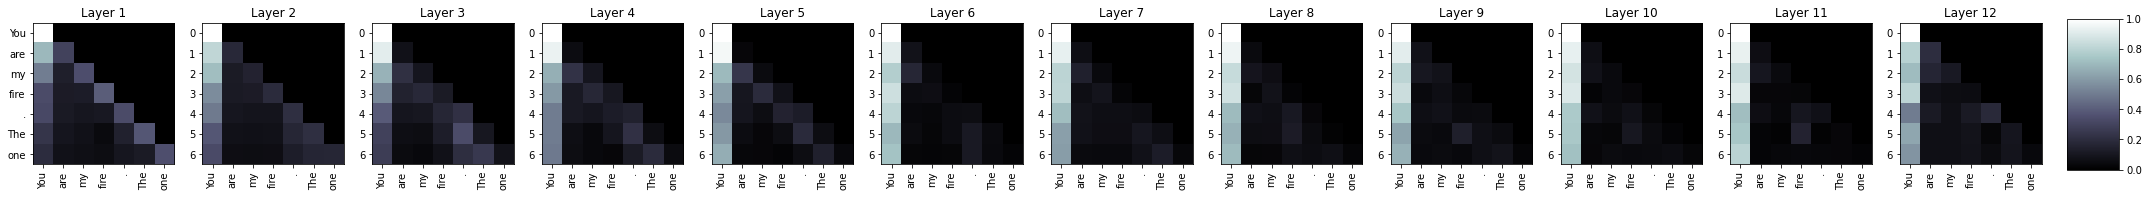

6400it [05:09, 18.51it/s]

  Step 6,400  of  9,953. Loss: 3.4378743171691895.   Elapsed: 0:05:09.
> flow. And pray. And pray. And pray, and let it flow. And pray. And pray. And pray, and let it flow. And pray. And pray. And pray, and let it flow. And pray. And pray. And pray, and let it flow. And pray. And pray. And pray, and let it flow. And pray. And pray, and let it flow. And pray. And pray. And pray, and let it flow. And pray. And pray, and let it flow. And pray. And pray. And pray, and let it flow. And pray. And pray. And pray, and let it flow<|endoftext|>.<|endoftext|>

<|endoftext|>.<|endoftext|>

<|endoftext|>

<|endoftext|>

<|endoftext|>
 who -> 0.3356970548629761
 that -> 0.32701370120048523
 I -> 0.21608516573905945
 you -> 0.08410653471946716
 with -> 0.011078853160142899
 and -> 0.006345907226204872
 in -> 0.006084853317588568
 thing -> 0.005343422759324312
 to -> 0.004919925704598427
 of -> 0.0033246478997170925


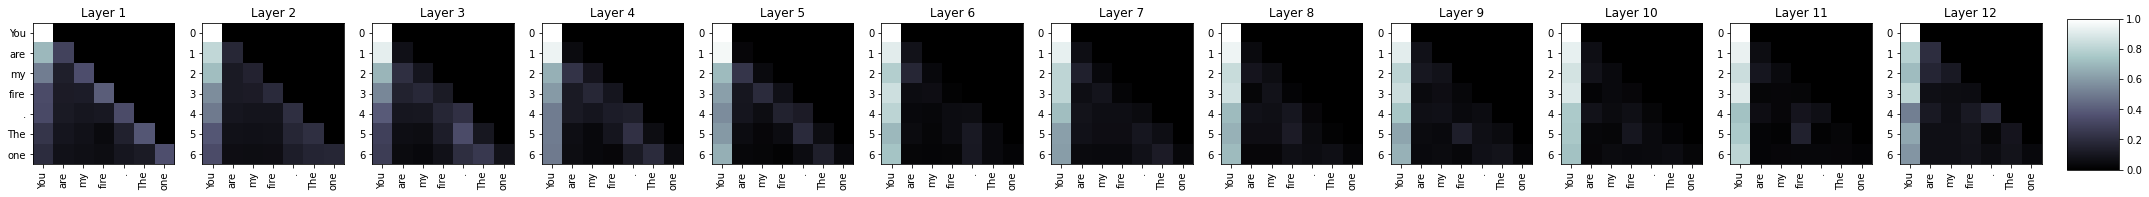

9598it [07:44, 21.28it/s]

  Step 9,600  of  9,953. Loss: 1.2456800937652588.   Elapsed: 0:07:45.
>You don't care what he says." He seemed to give it another try, that's all. It's a pleasure, that smile is shining. What we see, we hear. It's all that and the people around me. Oh, yeah, it's all that and the people around me. Oh, yeah, it's all that and the people around me. Oh, yeah, it's all that and the people around me. Oh, yeah, it's all that and the people around me. Well, I'm standing in a corner, I'm standing in a corner. Well, I'm standing in a corner, I'm standing in a corner. Hey, I'm there with you. I'm here with you from your hotel. I'm standing in a corner, I'm standing in a corner. Well, I'm standing in a corner, I'm standing in a corner. Well, I'm standing in a corner, I
 who -> 0.33628222346305847
 that -> 0.33019837737083435
 I -> 0.21286378800868988
 you -> 0.07922826707363129
 with -> 0.0119553841650486
 and -> 0.00740301888436079
 in -> 0.006272945553064346
 thing -> 0.005977015942335129
 to 

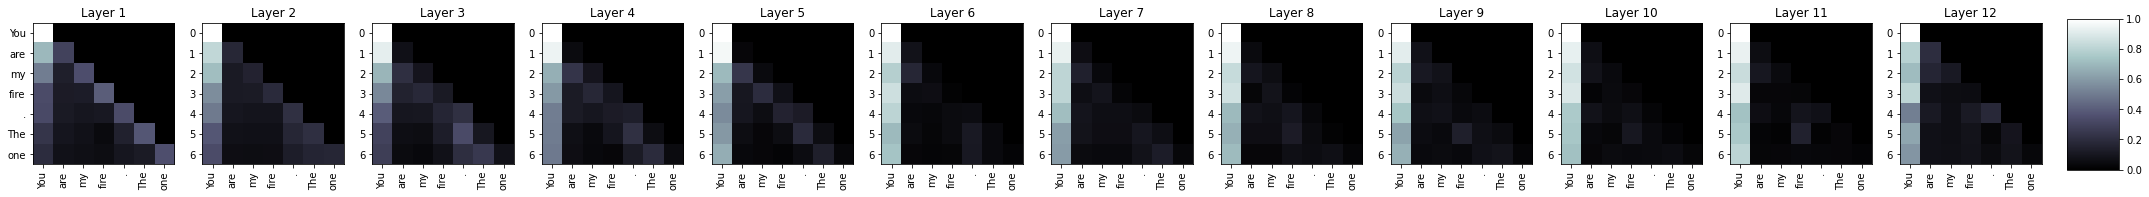

9953it [08:04, 20.56it/s]



  Average training loss: 2.50
  Training epoch took: 0:08:04

Running Validation...
  Validation Loss: 2.47
  Validation took: 0:00:09


3it [00:00, 22.62it/s]


======== Epoch 13 / 21 ========
Training...


3199it [02:33, 23.89it/s]

  Step 3,200  of  9,953. Loss: 3.0709431171417236.   Elapsed: 0:02:33.
> think that's my first line of defense. And I try to get the picture straight. To say to 'oh baby, they are all wrong'. When I'm on the phone with your girl. Hey, I'm in the middle of a game today. On the phone. 'Hey, I'm at the party and I'm gonna sing your praises. When I'm alone on my couch. Hey, I'm at the party and I'm gonna sing your praises. When I'm alone on my couch. 'Hey, I'm just waiting for this girl. I hope you don't mind. She can play her favorite tune. And I can't feel the pain. When I get the call. I'm out drunk. I'm so lonely. I'm scared. I'm not that good at singing. When I'm alone on my couch. Hey, I'm just waiting for this girl. I hope you don't mind. She can play
 that -> 0.3482086956501007
 who -> 0.3359694182872772
 I -> 0.19977644085884094
 you -> 0.07626288384199142
 with -> 0.011502734385430813
 thing -> 0.006738161202520132
 and -> 0.006616358645260334
 to -> 0.005852027330547571
 in -> 0

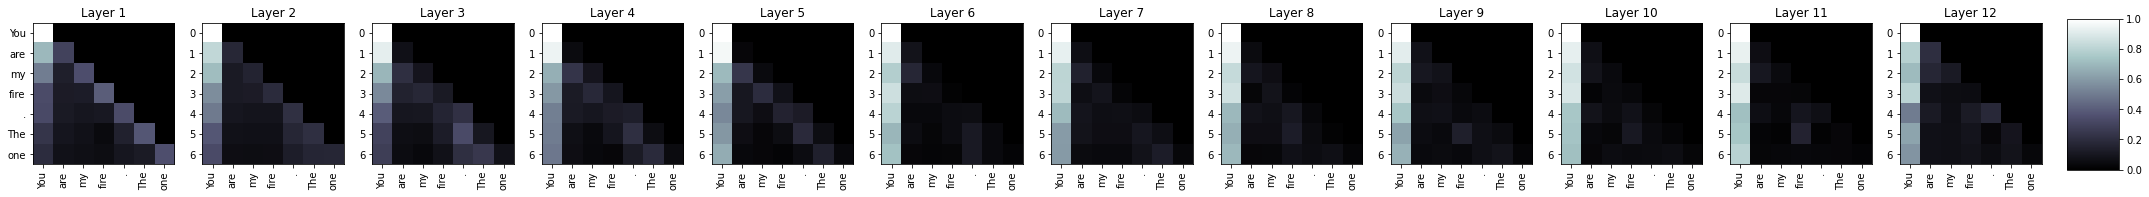

6399it [05:08, 21.90it/s]

  Step 6,400  of  9,953. Loss: 3.743196964263916.   Elapsed: 0:05:09.
> from another plane or two. We're traveling on the highway and we're driving on a highway. Don't we know the reason why you're here?. Why you're here?. Why you're here?. I always thought you were a wise man. And it's still true. Who's the king of all your troubles?. Why you're here?. Why you're here?. Let's start a mission. Let's go through another dimension. Let's get out here. Let's make it out of this world. Let's go down this world. Let's get out here. Let's go down this world. Who's the king of all your troubles?. Why you're here?. Why you're here?. Let's start a mission. Let's go through another dimension. Let's get out here<|endoftext|><|endoftext|><|endoftext|><|
 who -> 0.3468358814716339
 that -> 0.3419775068759918
 I -> 0.2052130252122879
 you -> 0.06829238682985306
 with -> 0.011507055722177029
 and -> 0.0062950109131634235
 thing -> 0.005892089102417231
 in -> 0.005538188852369785
 to -> 0.0053600622341

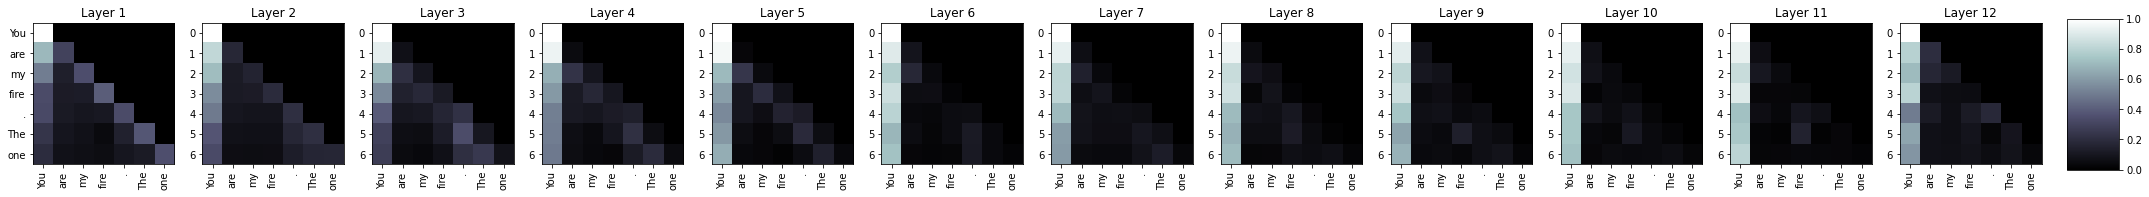

9598it [07:46, 22.56it/s]

  Step 9,600  of  9,953. Loss: 3.9259531497955322.   Elapsed: 0:07:47.
> one wish from you but I'm ready to walk away if you give me a reason. But it's not my fault that I don't love you. I'm not going out on a limb but you make my day. And I wish I could find you where I'm from. But I still need some time. I can't believe I'm walking away. You remind me of two little girls I've known. And I'm not even sure what kind of girl you are. If there's no reason to be sad. I wish I could find you where I'm from. But I still need some time. I can't believe I'm walking away<|endoftext|> But you remind me of two little girls I've known.<|endoftext|>

RAW Paste Data

<|endoftext|> By: C.A. C. G. Lick. I'm not gonna say goodbye. But
 who -> 0.37244242429733276
 that -> 0.31164348125457764
 I -> 0.20456016063690186
 you -> 0.07272978872060776
 with -> 0.011964472010731697
 to -> 0.006136550568044186
 and -> 0.00602102791890502
 thing -> 0.005722294095903635
 in -> 0.005708994343876839
. -> 0.0030708

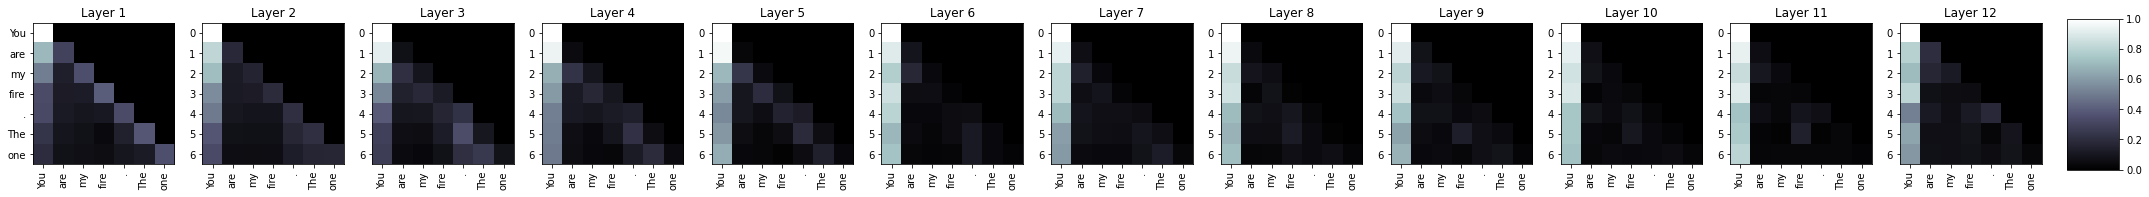

9953it [08:06, 20.48it/s]



  Average training loss: 2.50
  Training epoch took: 0:08:06

Running Validation...
  Validation Loss: 2.47
  Validation took: 0:00:09


3it [00:00, 21.77it/s]


======== Epoch 14 / 21 ========
Training...


3200it [02:32, 19.05it/s]

  Step 3,200  of  9,953. Loss: 2.47257399559021.   Elapsed: 0:02:33.
> fade. When you don't know the dance on the dance floor. Just turn around and give it all away. Yeah, the beat breaks up the beat. You think that just in you, yeah, you try, you know. You try, you know. But when you gotta make a mistake. Sometimes you gotta make a mistake. I gotta make a mistake. I gotta make a mistake. I wanna see all the people that I've met before. Who never cared where we've gone. I wanna see all the people that I've met before. Where we've gone, all the world, all the people. The guys that you heard about. Like you guys and you guys and you guys. The only thing I know, I know that you're just wrong. Just make a mistake and you'll fall, yeah, yeah. Just make a mistake and you'll fall, yeah. Just make a mistake and you'll fall, yeah, yeah
 who -> 0.4125286638736725
 that -> 0.2972330152988434
 I -> 0.18299983441829681
 you -> 0.0714028924703598
 with -> 0.011612353846430779
 in -> 0.00575840845704

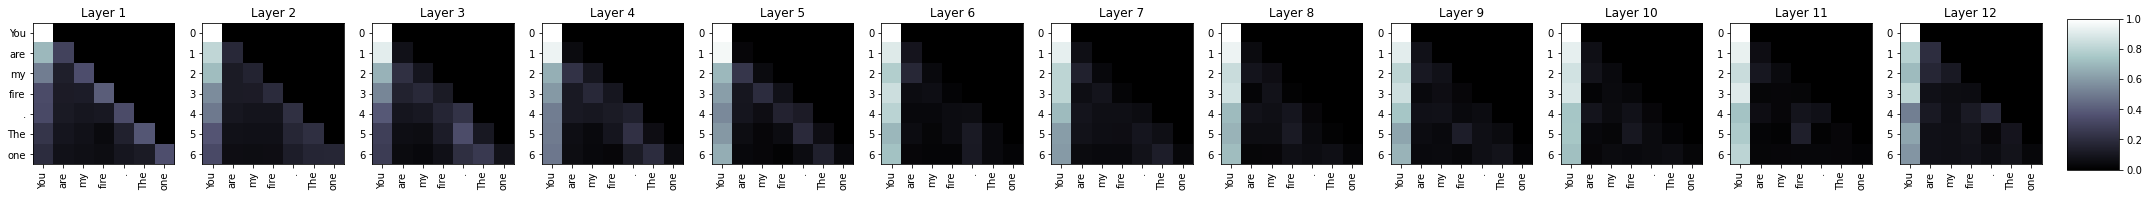

6400it [05:09, 18.26it/s]

  Step 6,400  of  9,953. Loss: 1.8017088174819946.   Elapsed: 0:05:09.
> to go. For someone like me. That doesn't understand. I'm really trying to live my life. No one can make me move. Or leave me hanging. I just wish I could be somewhere else. For someone like me. That doesn't understand. He got to be lonely. He'll run away. Or live off his trust. Or leave me hanging. He'll run away. Or live off his trust. Or leave me hanging. He'll run away. Or live off his trust. Or leave me hanging<|endoftext|><|endoftext|>

RAW Paste Data

<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|
 who -> 0.4011717438697815
 that -> 0.30522796511650085
 I -> 0.18278633058071136
 you -> 0.07365990430116653
 with -> 0.012392730452120304
 and -> 0.006275109015405178
 thing -> 0.005755728576332331
 in -> 0.005753752775490284
 to -> 0.004338424652814865
. -> 0.0026383427903056145


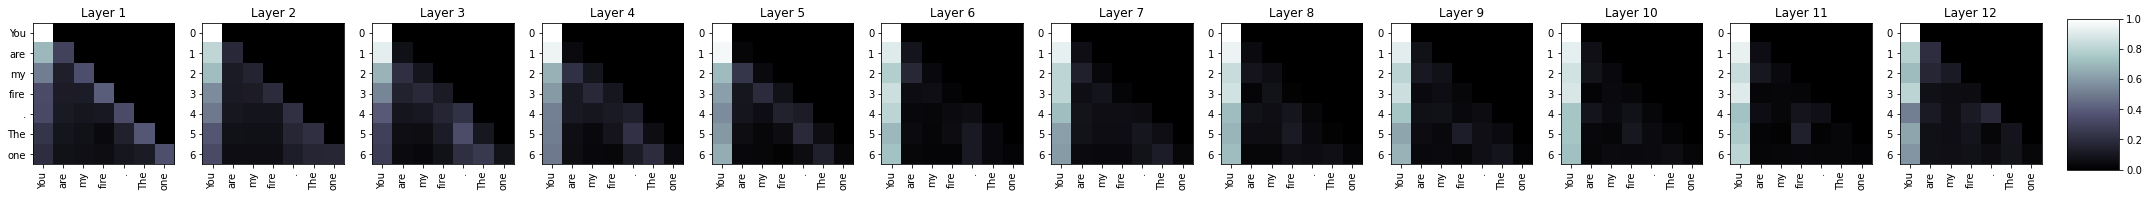

9600it [07:46, 16.56it/s]

  Step 9,600  of  9,953. Loss: 2.64971923828125.   Elapsed: 0:07:47.
>'ve tried to stay safe. And try to make my mark. All I want is love to live. I've tried to stay safe. Oh oh oh oh oh oh oh oh but I'm not gonna. You're so beautiful I can't wait for you. You're so beautiful I can't wait for you. But you don't have to be alone. You're so beautiful I can't wait for you. And you don't have to be alone. I got a smile on my face. I don't believe when I look back. I'm not gonna lie but I'm not gonna. You're so beautiful, you've got that smile. And you got a smile on your face. And you got a smile on your face. Your beauty is so great (it's just like). Your smile is so beautiful. And you got that smile on your face. And you got a smile on your face. Your beauty is so great. You
 who -> 0.37860020995140076
 that -> 0.312599241733551
 I -> 0.1966371238231659
 you -> 0.07463104277849197
 with -> 0.011870491318404675
 and -> 0.006879344116896391
 in -> 0.006002055946737528
 thing -> 0.005155142

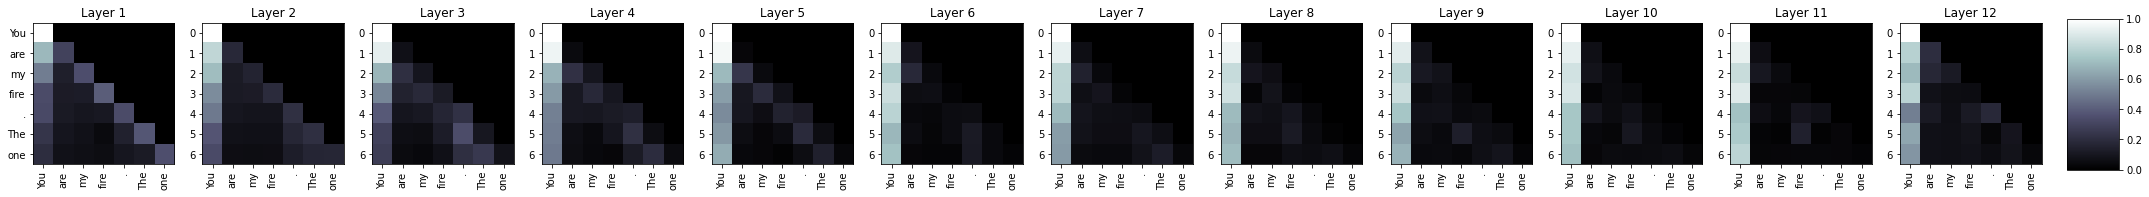

9953it [08:06, 20.46it/s]



  Average training loss: 2.49
  Training epoch took: 0:08:07

Running Validation...
  Validation Loss: 2.47
  Validation took: 0:00:09


3it [00:00, 24.87it/s]


======== Epoch 15 / 21 ========
Training...


3199it [02:32, 21.36it/s]

  Step 3,200  of  9,953. Loss: 3.62831974029541.   Elapsed: 0:02:33.
>6-9-19]. The first couple of years we were living on the road. I always held her warm as she passed by. She's always ready to welcome. We can't be alone. We can be together. Please tell me, please tell me a little. How could you make it through that cold. In a world that was frozen, only on that moon. For so long. We know you've been crying. And the days we spent together. Were nothing but a dream. For so long. Tonight I'm holding her warm as she passes by. She's always ready to welcome. We can't be alone. We can be together. Please tell me, please tell me a little. How could you make it through that cold. Tonight I'm holding her warm as she passes by. This girl has come to make me cry<|endoftext|><|endoftext|><|endoftext|
 who -> 0.3996819853782654
 that -> 0.3083135187625885
 I -> 0.19114579260349274
 you -> 0.06460779160261154
 with -> 0.011749446392059326
 and -> 0.00673978216946125
 in -> 0.005995904095470905
 t

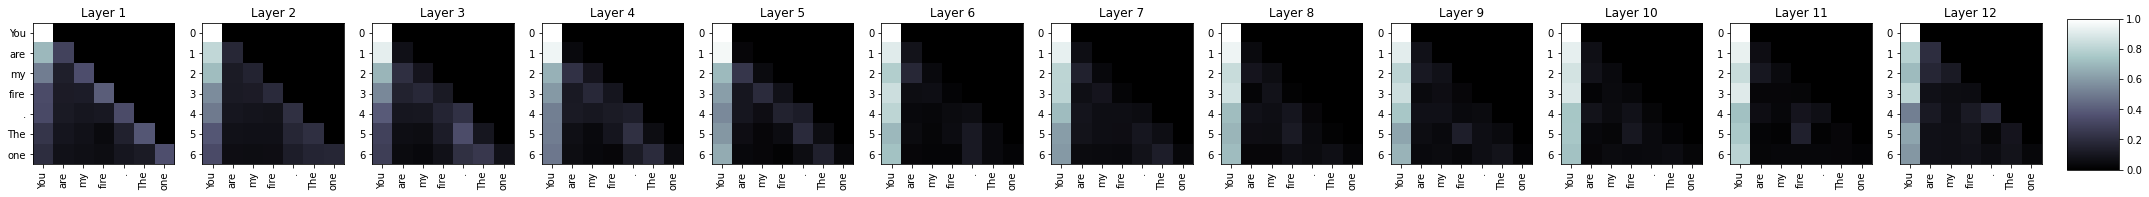

6399it [05:08, 20.57it/s]

  Step 6,400  of  9,953. Loss: 2.873727321624756.   Elapsed: 0:05:08.
>, oh, oh. Oh, oh, oh, oh. I love you, yes you do. Yes, yes, yes, yes. Oh, oh, oh, oh. Oh, oh, oh, oh. I love you, yes you do. Yes, yes, yes, yes. Oh, oh, oh, oh. Oh, oh, oh, oh. I love you, yes you do. Yes, yes, yes, yes. Oh, oh, oh, oh. Oh, oh, oh, oh<|endoftext|><|endoftext|>Get daily news updates directly to your inbox Subscribe Thank you for subscribing We have more newsletters Show me See our privacy notice Could not subscribe, try again later Invalid Email
, by David L. Jaffe.
Chorus:<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|end
 who -> 0.35611993074417114
 that -> 0.3393171727657318
 I -> 0.19359393417835236
 you -> 0.07367363572120667
 with -> 0.011304167099297047
 and -> 0.0070266323164105415
 in -> 0.006008363328874111
 thing -> 0.005593535490334034
 to -> 0.004750323947519064
 on -> 0.002612333046272397


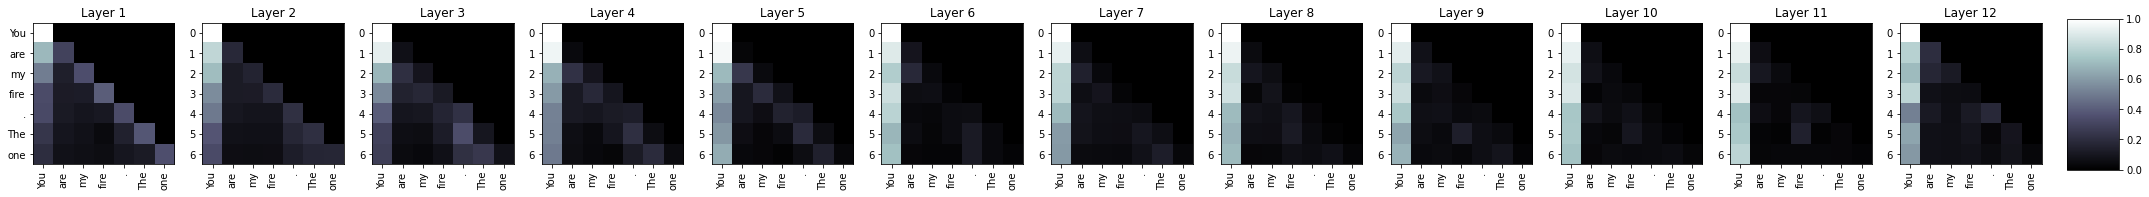

9598it [07:45, 20.48it/s]

  Step 9,600  of  9,953. Loss: 1.41164231300354.   Elapsed: 0:07:46.
>'s no place to go for you. You must be gone soon. Please take the time to look out for me. I wanna see you. Don't get mad, don't get hurt. If you'll be okay, I'll be there. The rest of your life in the end. But I can't do that, no matter how hard you try. Just remember, you're my friend. Don't ever give up on me. I'm going to find you. I can't stop your tears, please don't give up on me. I'm calling you baby. I'm calling you baby<|endoftext|>. Keep moving on<|endoftext|><|endoftext|>.<|endoftext|><|endoftext|>

RAW Paste Data

<|endoftext|><|endoftext|><|endoftext|><|end
 who -> 0.34976163506507874
 that -> 0.3480871617794037
 I -> 0.18953348696231842
 you -> 0.07521655410528183
 with -> 0.011766464449465275
 and -> 0.0066680097952485085
 thing -> 0.005703755654394627
 in -> 0.005335379391908646
 to -> 0.005045850295573473
. -> 0.00288173696026206


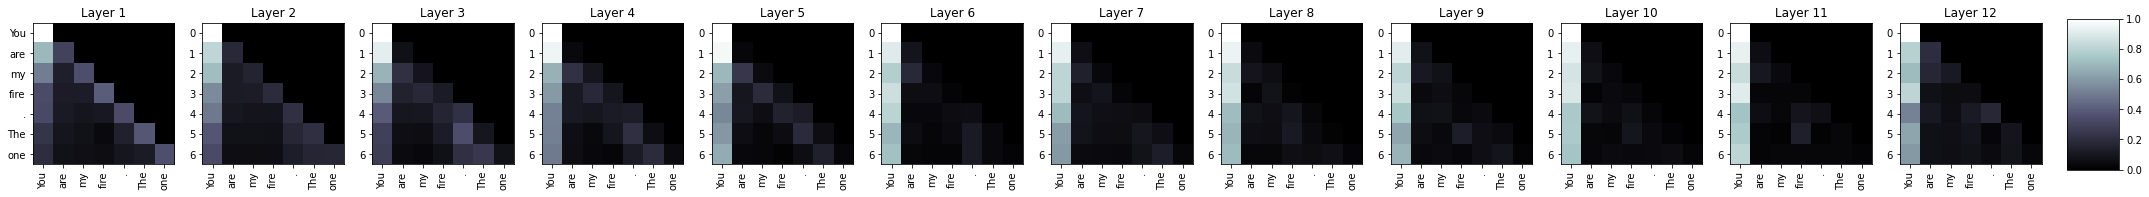

9953it [08:05, 20.52it/s]



  Average training loss: 2.49
  Training epoch took: 0:08:05

Running Validation...
  Validation Loss: 2.46
  Validation took: 0:00:09


3it [00:00, 21.69it/s]


======== Epoch 16 / 21 ========
Training...


3198it [02:32, 21.58it/s]

  Step 3,200  of  9,953. Loss: 1.6558572053909302.   Elapsed: 0:02:33.
>o de los mals. Gomes a los nombres los no los los es han las dey. Mello que los nombres los no los es han las. Cualías por la el mundo es los años de las. I'm going to be back sometime tonight. It feels like I can't sleep this morning. I don't know what that is but I don't know. I don't care no longer. I don't care no longer. If you're gonna keep me. in this darkness. I'll need you no more. I'll love you no more. A man I love ain't gone, isn't there a change in my mind?. You don't deserve to be here. Please don't let the pain keep your soul from growing stronger. I love you no more. I'll love you no more. I will love you no more. I will love you no more
 who -> 0.3570111393928528
 that -> 0.33756035566329956
 I -> 0.1909223198890686
 you -> 0.07721437513828278
 with -> 0.010942556895315647
 and -> 0.00697368523105979
 to -> 0.005555242300033569
 in -> 0.005213573575019836
 thing -> 0.004708957392722368
. -> 0.00389

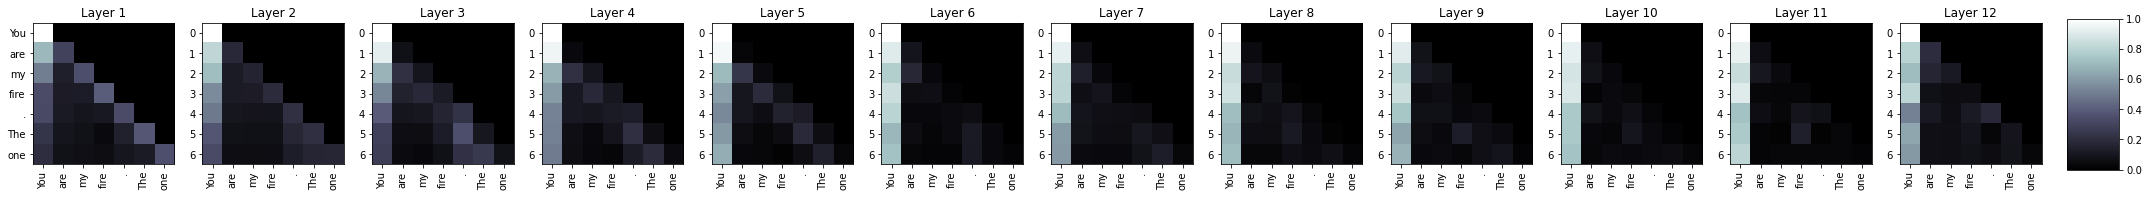

6400it [05:09, 18.89it/s]

  Step 6,400  of  9,953. Loss: 3.2402522563934326.   Elapsed: 0:05:09.
> thing in life. It's the most important thing that we cannot do. This is the first time that I've been hurt.. And I cried every time I saw it. But I got nothing and nothing left.. And I cried every time I saw it, but I got nothing left.. And I cried every time I saw it, but I got nothing left. And I cried every time I saw it, and i got nothing left.. I think of all these people. I think of all these people. When i was the first one. We'd go at it all the time.. But we got nothing to do and nothing to say.. And I cried every time I saw it. But I got nothing left.. And I cried every time i saw it, but I got nothing left.. And I cried every time i saw it, but I got nothing left.. And I cried every time I saw it, but I got nothing left.. And I cried
 that -> 0.3484889268875122
 who -> 0.33892351388931274
 I -> 0.19952580332756042
 you -> 0.07396133244037628
 with -> 0.010993538424372673
 and -> 0.0079201003536582
 to -

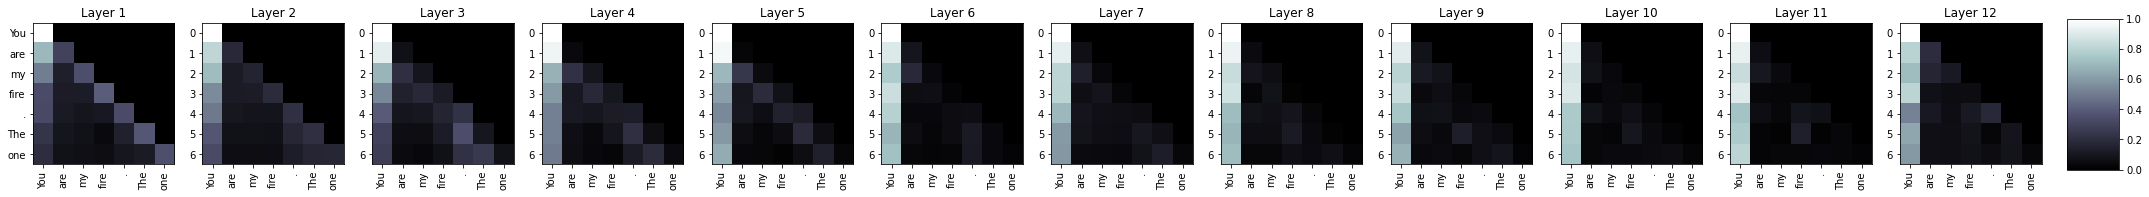

9598it [07:44, 20.28it/s]

  Step 9,600  of  9,953. Loss: 3.4117684364318848.   Elapsed: 0:07:45.
> what we'd seen. In one place the moon was shining hot. I saw the sun go down. When the sun went down on them. My heart was exploding. I saw they'd be dead. I saw the sun go down. When the sun went down on them. My heart was exploding. I saw they'd be dead. I saw the sun go down. When the sun went down on them<|endoftext|>

The only thing I could recall was the morning. From the morning I woke up. And I went to say goodbye<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><
 that -> 0.35176002979278564
 who -> 0.33753153681755066
 I -> 0.19942469894886017
 you -> 0.07220645248889923
 with -> 0.011231474578380585
 and -> 0.007838261313736439
 to -> 0.005873811896890402
 in -> 0.005685627926141024
 thing -> 0.004579103551805019
. -> 0.003868957981467247


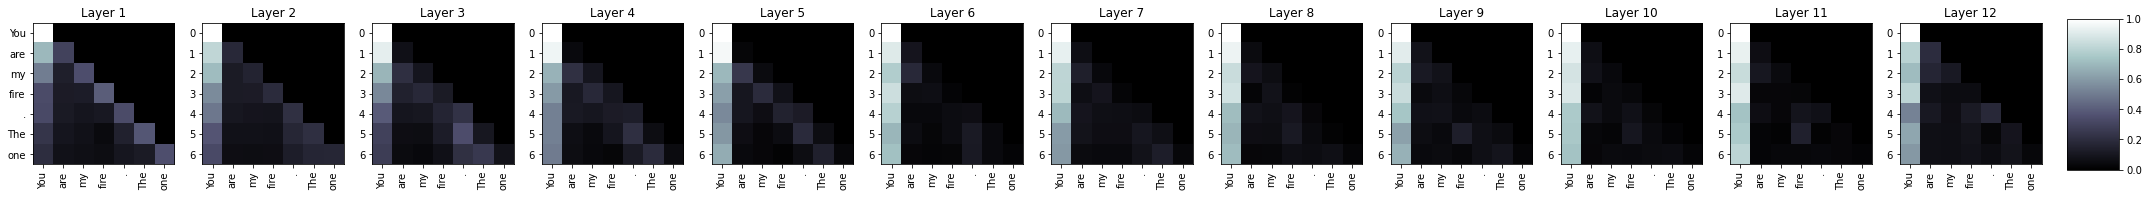

9953it [08:04, 20.54it/s]



  Average training loss: 2.49
  Training epoch took: 0:08:04

Running Validation...
  Validation Loss: 2.46
  Validation took: 0:00:09


3it [00:00, 20.79it/s]


======== Epoch 17 / 21 ========
Training...


3200it [02:33, 20.44it/s]

  Step 3,200  of  9,953. Loss: 2.1431703567504883.   Elapsed: 0:02:33.
> be real. We're just living together like we're married. Let's just let it go. No one wants to hear that. The whole world's a mess and we need the peace. They're breaking my heart. They're breaking my heart. You're hurting me. They're breaking my heart. I say no. They're breaking my heart. I don't want to hear that. A girl was hurt. A kid was bruised. She's hurting me. You're hurting me. They're breaking my heart. They're breaking my heart. I say no. They're breaking my heart. I don't want to hear that. A girl was hurt. A kid was bruised. They're breaking my heart. They're breaking my heart. Let it go. No one wants to hear that. The whole world's a mess and we need the peace. They're breaking my heart. They're breaking my heart. Let it go. Let
 who -> 0.3509046137332916
 that -> 0.335541307926178
 I -> 0.1983320116996765
 you -> 0.07362097501754761
 with -> 0.01195564866065979
 and -> 0.008163313381373882
 to -> 0.

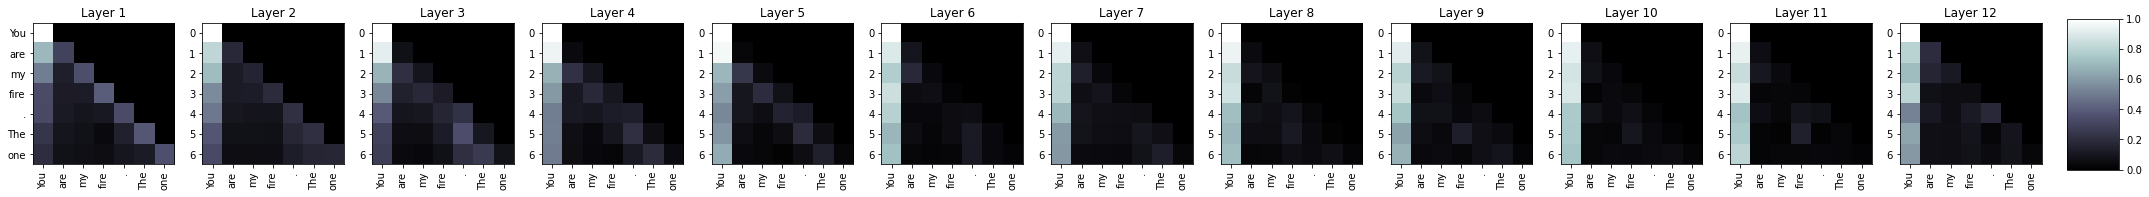

6400it [05:09, 20.12it/s]

  Step 6,400  of  9,953. Loss: 2.3125967979431152.   Elapsed: 0:05:10.
> thing that you know. Every day is the same, we all play it all out. For the love of God, that's all that matters to you. Every day is the same, we all play it all out. So, now we're getting closer and closer. You're going to cry no, no, no. There's so much more we can do. I just want to hear it all. So, now go ahead and stay. We can be together forever. I can't help but think you're so good. So, now we're getting closer and closer. You're going to cry no, no, no. There's so much more we can do. I just want to hear it all. So, now we're getting closer and closer. You're going to cry no, no, no. There's so much more we can do. I just want to hear it all. So, now we're getting closer and
 that -> 0.35064685344696045
 who -> 0.33814123272895813
 I -> 0.1886855810880661
 you -> 0.07907402515411377
 with -> 0.012338990345597267
 and -> 0.008681233040988445
 to -> 0.006482625380158424
 in -> 0.005965926684439182
 thing -

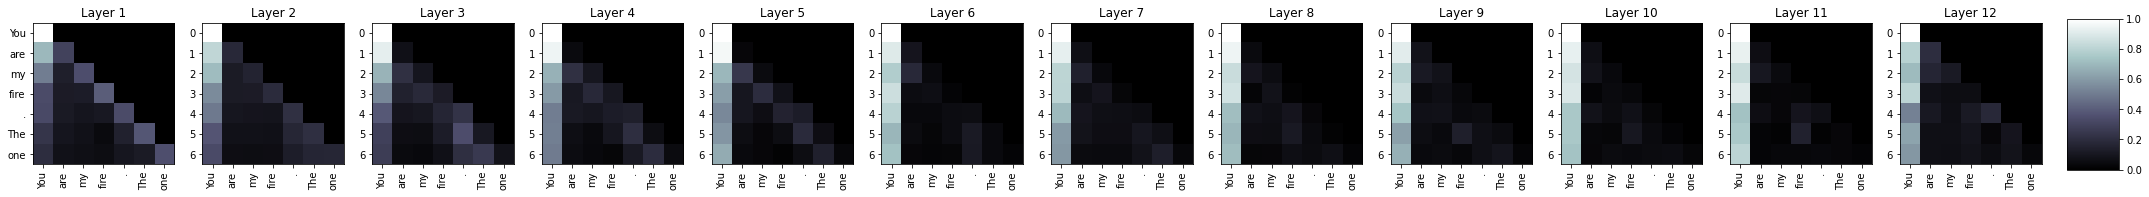

9599it [07:45, 23.81it/s]

  Step 9,600  of  9,953. Loss: 2.293736696243286.   Elapsed: 0:07:46.
> love you little things like this. (Chorus). When I was young. I was good, good, nice, nice. And now I'm grown man for good. And this is the world I belong to. But this is the world I belong to. What do you believe?. Let's just leave it at that. I know this world is my paradise, let's go back. Let's go back back, let's go back, let's go back, let's go back. I'm old and sick and I need a good home from here on out. There's no point in fighting. But I always say it ain't so, ain't it?. So you know it doesn't always work this way. So I'm tired, tired of fighting, tired of fighting. Don't take this from me. So you know it ain't so. So you know it ain't so. It ain't so long, ain
 who -> 0.3513927757740021
 that -> 0.34225907921791077
 I -> 0.18664893507957458
 you -> 0.07784662395715714
 with -> 0.012612296268343925
 and -> 0.008393015712499619
 to -> 0.006182722747325897
 in -> 0.005816778168082237
 thing -> 0.004677908

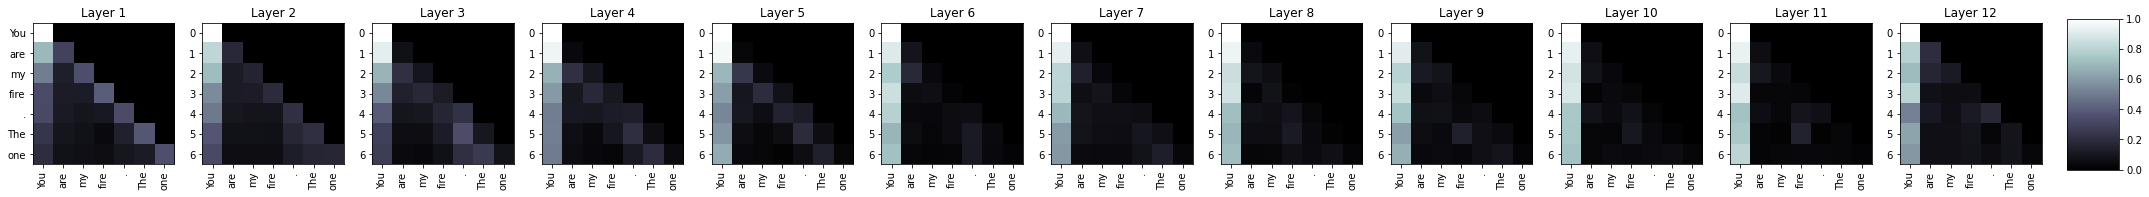

9953it [08:05, 20.50it/s]



  Average training loss: 2.49
  Training epoch took: 0:08:06

Running Validation...
  Validation Loss: 2.46
  Validation took: 0:00:09


3it [00:00, 26.01it/s]


======== Epoch 18 / 21 ========
Training...


3199it [02:32, 19.73it/s]

  Step 3,200  of  9,953. Loss: 2.043710470199585.   Elapsed: 0:02:33.
>. What do I do now?. I'm gonna get the life. It's been a hard road in my journey. It's been a hard road in my journey. It's been a hard road in my journey. There's nothing more to see. Nothing to hear. Nothing else to hope. But it's been a hard time. It's been a hard time. There's nothing more to see. Nothing to hear. Nothing else to hope. But it's been a hard time. (You've made it this far, all alone). You're so lonely. Don't want to give up. To say goodbye. To make a difference in your life. I know I'm the only one who is feeling the pain. But then it's not true. And I can't bear to see you fall. It feels like I'm lost. You can't see. Nothing more to say. Nothing else to hope. But it's been a
 that -> 0.34692639112472534
 who -> 0.3421763777732849
 I -> 0.19362321496009827
 you -> 0.07710324227809906
 with -> 0.011953325942158699
 and -> 0.00754122668877244
 to -> 0.005926225800067186
 in -> 0.005860491190105677
 

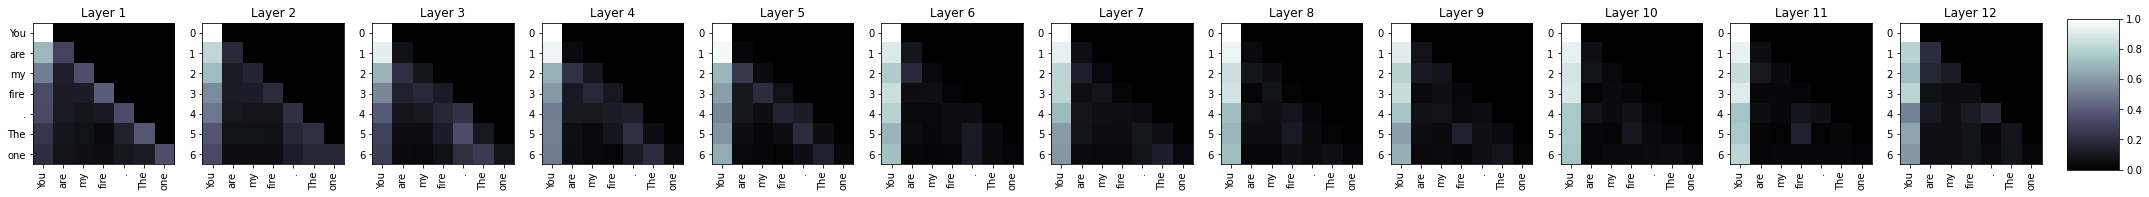

6400it [05:09, 19.87it/s]

  Step 6,400  of  9,953. Loss: 2.1985976696014404.   Elapsed: 0:05:10.
> so beautiful, they are so beautiful. So beautiful, so beautiful, so beautiful, so beautiful.<|endoftext|>

<|endoftext|> Oh, look at that. Look at that. Look at that. Look at that.<|endoftext|> And then I see some trees grow. Well they are. Trees grow. And trees grow.<|endoftext|><|endoftext|><|endoftext|>

<|endoftext|> Yeah, look at that.<|endoftext|> <|endoftext|> Yes, look at that. Look at that.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><
 that -> 0.35537847876548767
 who -> 0.32242003083229065
 I -> 0.20515383780002594
 you -> 0.07759600132703781
 with -> 0.011295014061033726
 and -> 0.007513316348195076
 to -> 0.0059894984588027
 in -> 0.0055554634891450405
 thing -> 0.005368828773498535
. -> 0.0037294491194188595


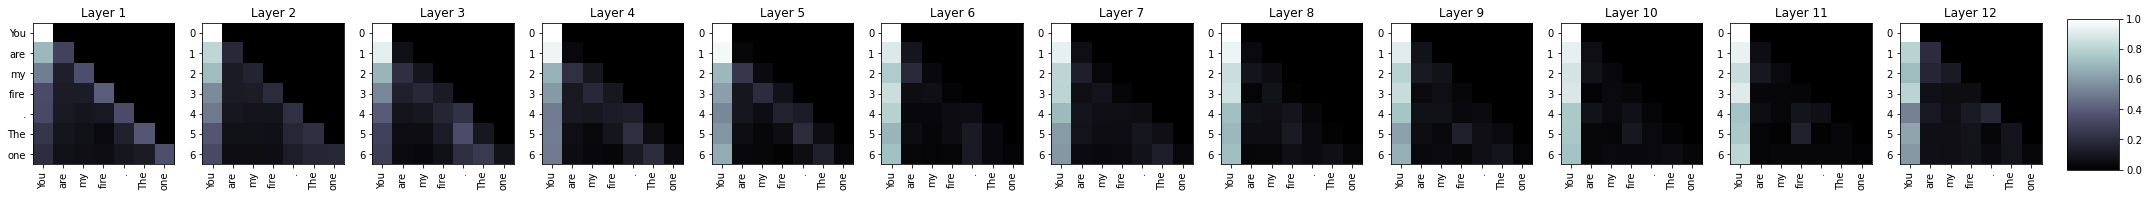

9599it [07:46, 21.86it/s]

  Step 9,600  of  9,953. Loss: 2.1446268558502197.   Elapsed: 0:07:46.
> To find out why I'm the way I am?. In love you know that you want me to. To take back that you have. Lost the way that I did and you don't know. I'd have you know that I'd be alright with it. As in nothing at all. The way I looked like I should have been. You told me my life would be alright. I told you I'd get it. Once and for all. I'd have you know what you wanted me to be. I'd have you know that I'd be alright with it. Like I had when I was a child. How I looked like I should have been. How I looked like I should have been. But I couldn't believe you would want me to. I'd have you know what you hoped for me to be. What I needed to know was I wanted to be you. I want you know that you want me to be. I
 that -> 0.3527163863182068
 who -> 0.3225564956665039
 I -> 0.2104944884777069
 you -> 0.07578025013208389
 with -> 0.010934936814010143
 and -> 0.007369483355432749
 to -> 0.006031109485775232
 in -> 0.0053917528

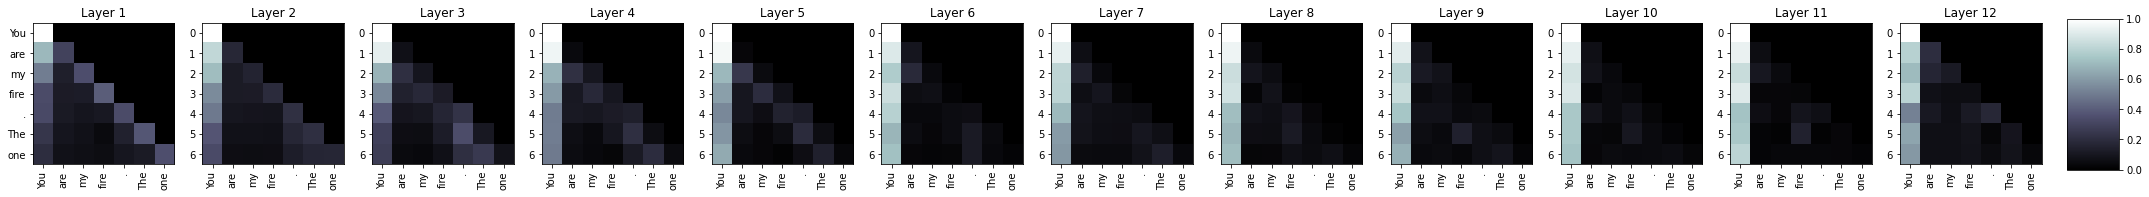

9953it [08:05, 20.51it/s]



  Average training loss: 2.48
  Training epoch took: 0:08:05

Running Validation...
  Validation Loss: 2.46
  Validation took: 0:00:09


3it [00:00, 19.66it/s]


======== Epoch 19 / 21 ========
Training...


3200it [02:33, 21.50it/s]

  Step 3,200  of  9,953. Loss: 2.4518182277679443.   Elapsed: 0:02:34.
> woman!<|endoftext|> You'd never know just how much love I got for you.<|endoftext|> I'm on my way to the moon<|endoftext|><|endoftext|><|endoftext|> I'll be driving your love<|endoftext|> to me.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|end oftext|><|endoftext|><|endoftext|><|endoftext|><
 that -> 0.35242557525634766
 who -> 0.3383740186691284
 I -> 0.19859227538108826
 you -> 0.0721011683344841
 with -> 0.011098655872046947
 and -> 0.0074162352830171585
 to -> 0.005925698671489954
 in -> 0.005477909464389086
 thing -> 0.004934325814247131
. -> 0.00365411676466465


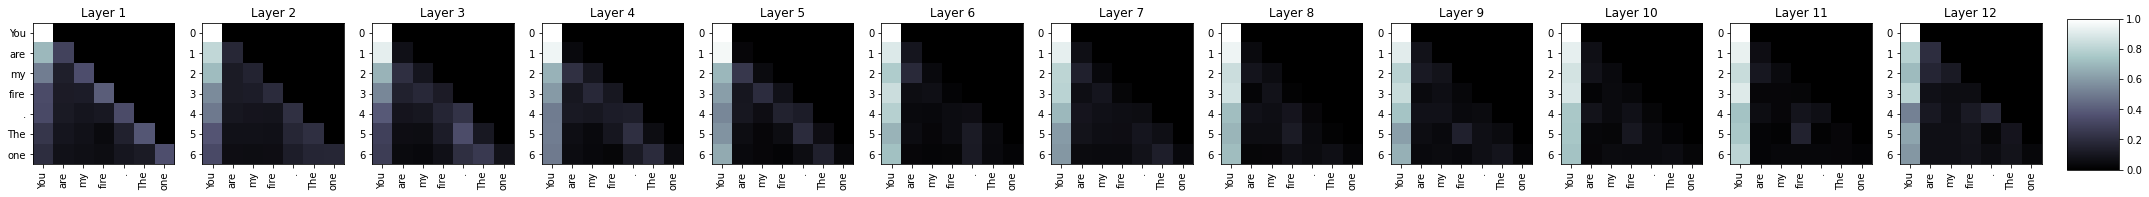

6399it [05:09, 20.41it/s]

  Step 6,400  of  9,953. Loss: 2.756978750228882.   Elapsed: 0:05:09.
>. There's a big black sky. And it's getting dark. And it's getting dark. And it's getting dark. And it's getting dark. And it's getting dark. And it's getting dark. And it's getting dark. And it's getting dark. And it's getting dark. And it's getting dark. And it's getting dark. And it's getting dark. And it's getting dark. And it's getting dark. And it's getting dark. And it's getting dark. And it's getting dark.<|endoftext|> 13:11:45<|endoftext|> 13:11:45<|endoftext|> 13:11:45<|endoftext|> 13:11:45<|endoftext|> 13:11:45<|endoftext|> 13:11:45<|endoftext|> 13:11:
 that -> 0.3541228771209717
 who -> 0.3350977897644043
 I -> 0.19745877385139465
 you -> 0.07405905425548553
 with -> 0.011276507750153542
 and -> 0.007356317713856697
 in -> 0.005701547954231501
 to -> 0.005639208946377039
 thing -> 0.005398652516305447
. -> 0.0038891856092959642


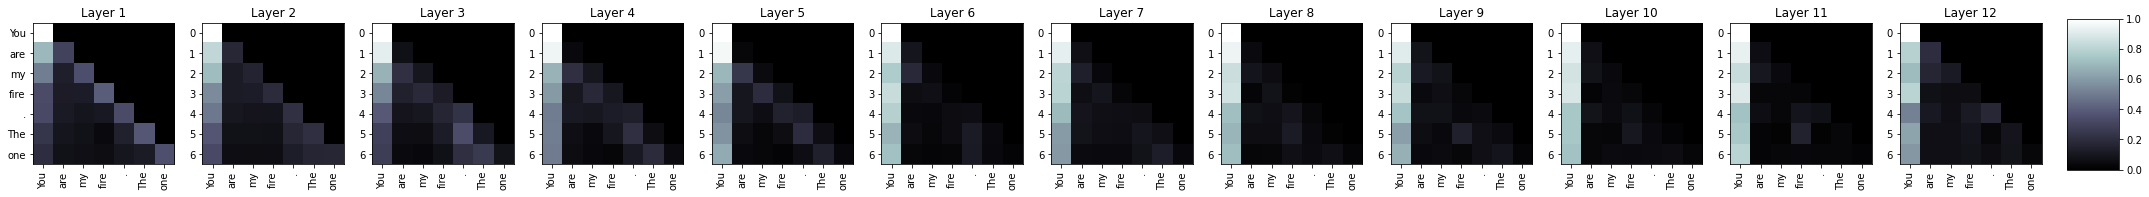

9599it [07:45, 18.96it/s]

  Step 9,600  of  9,953. Loss: 2.3534421920776367.   Elapsed: 0:07:45.
> went to sleep in a pool of fire. A ghost could see us through. His eyes were full of tears of sorrow. The sun was shining, and we all cried. The rain was falling, heavy in the sea. The wind was blowing, and we all cried. We had the dream of the angels. Dreaming to be seen again. To say goodbye. To cry one final time. To get to know myself now. We went to bed. Then we went to sleep. The moon was shining, and we all cried. The sun was shining, and we all cried. The rain was falling, heavy in the sea. He said to us, "We must go, we must go. Down and out of the sky. We gotta go." And we went to sleep. Then we went to sleep. The moon was shining, and we all cried. The sun was shining, and we all cried. The rain was falling, heavy in
 that -> 0.34981420636177063
 who -> 0.33999958634376526
 I -> 0.19751667976379395
 you -> 0.07319089770317078
 with -> 0.011340908706188202
 and -> 0.007472530007362366
 in -> 0.0057131936

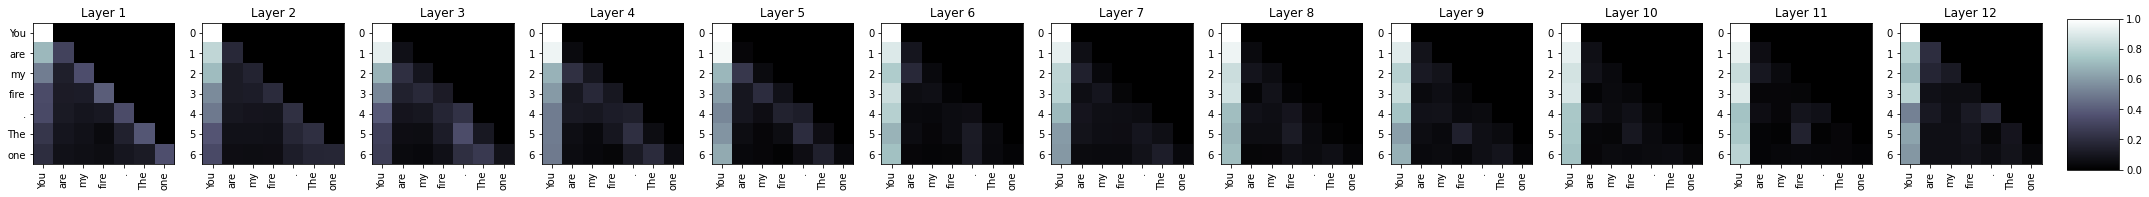

9953it [08:04, 20.54it/s]



  Average training loss: 2.48
  Training epoch took: 0:08:05

Running Validation...
  Validation Loss: 2.46
  Validation took: 0:00:09


3it [00:00, 20.98it/s]


======== Epoch 20 / 21 ========
Training...


3199it [02:33, 20.14it/s]

  Step 3,200  of  9,953. Loss: 2.753671169281006.   Elapsed: 0:02:33.
> more.. But I will take you out of there. She said that I was not a girl. If you'd stand up. She said that I am not no girl. If you'd stand up. She said that I was not a girl. I was not.. And now I'm sitting down in my bed.. And I'm afraid that something isn't right.. 'Cause I can hear your voice.. And I can see what it means. And my heartache and loneliness and pain are too deep.. And it's clear that you can't take comfort in what I know. Because I know that I know that you are inside me.. Well,. I hope that my life has made you so much. That you will be there for me and me alone. And when it comes to the truth. And when it comes to love, and hate,. You will come out of the wood. And when it comes to the truth. And when it comes to
 that -> 0.35220298171043396
 who -> 0.3375726044178009
 I -> 0.19899600744247437
 you -> 0.07225216180086136
 with -> 0.01122470386326313
 and -> 0.007425814867019653
 in -> 0.005543208

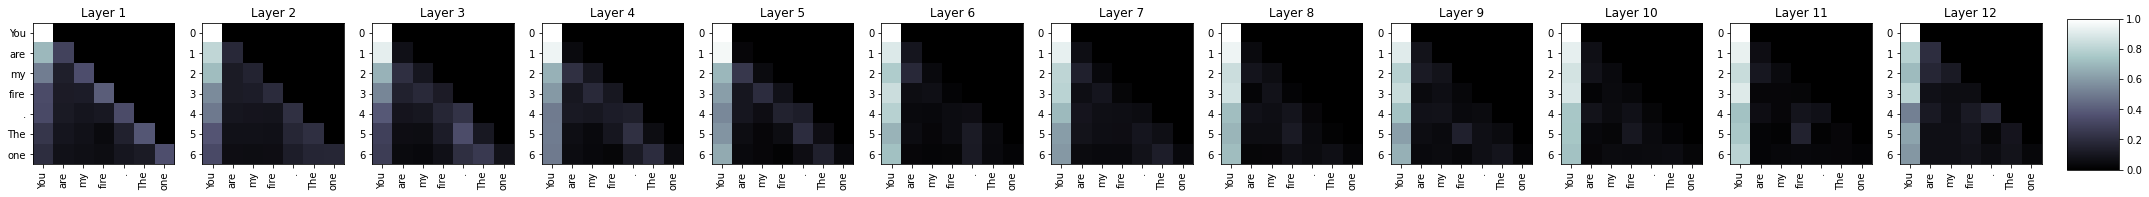

6398it [05:10, 21.10it/s]

  Step 6,400  of  9,953. Loss: 2.776076078414917.   Elapsed: 0:05:11.
> jail with a gun. He and the boys got into trouble. and the boy died by suicide. He said he was coming back to town. His son had to go home. All the rest died young. the whole town couldn't know no more. He cried and cried like a baby. He made a lot of friends. The boy was married and well. His daughter had come back with him. He went on the job. His son died by suicide. The whole town couldn't know no more. The boy was married and well. His daughter had come back with him. He went on the job. His son died by suicide<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><
 that -> 0.34879642724990845
 who -> 0.3418622314929962
 I -> 0.19722774624824524
 you -> 0.073270283639431
 with -> 0.011052119545638561
 and -> 0.00750435795634985
 in -> 0.005606414284557104
 to -> 0.005464688874781132
 thing -> 0.005185718648135662
. -> 0.004029992502182722


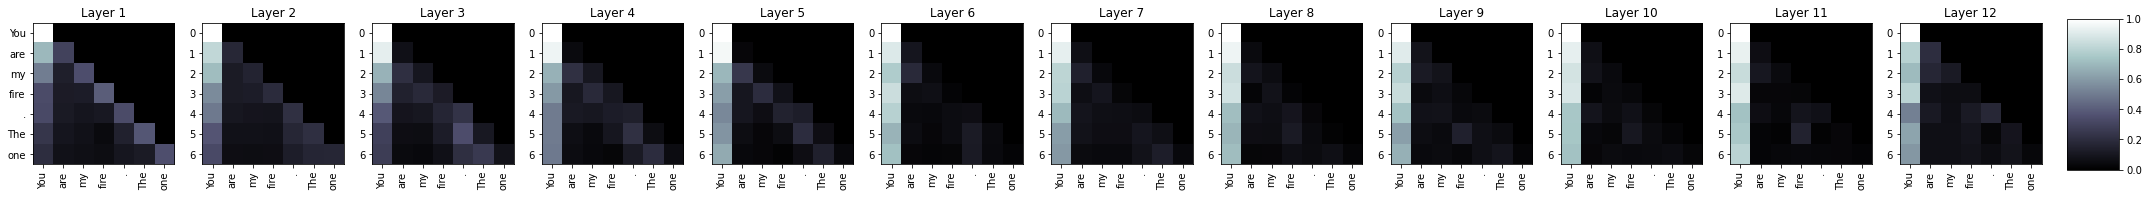

9600it [07:46, 22.30it/s]

  Step 9,600  of  9,953. Loss: 2.6588869094848633.   Elapsed: 0:07:46.
>. Just in the sky. Just in the sky. I'll be there. To see that sun. With a shine like a star. I will be there. To be in a place. I will be here. Please. Please. Please. Please, please, please. Please. Please. Please. Please, please, please. Please, please. Please, please, please. Please<|endoftext|>

<|endoftext|>


<|endoftext|> Hey. Hey. Hey. Hey. Hey. Hey. Hey<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext
 that -> 0.3507382273674011
 who -> 0.33740201592445374
 I -> 0.19872556626796722
 you -> 0.07403543591499329
 with -> 0.010904597118496895
 and -> 0.007683353964239359
 in -> 0.00579319940879941
 to -> 0.005456050857901573
 thing -> 0.005375480279326439
. -> 0.0038860186468809843


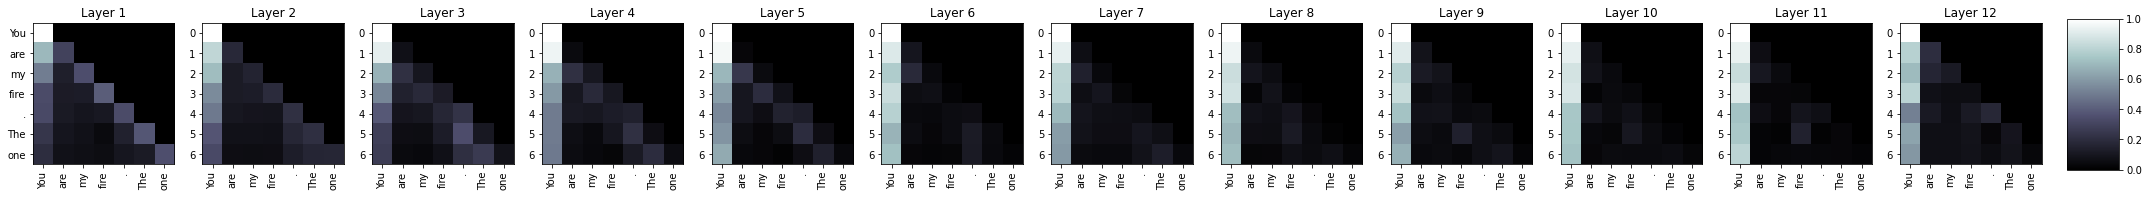

9953it [08:05, 20.48it/s]



  Average training loss: 2.48
  Training epoch took: 0:08:06

Running Validation...
  Validation Loss: 2.46
  Validation took: 0:00:09

Training complete!
Total training took 2:46:06 (h:mm:ss)


True

In [41]:
import regex as re

# Wandb manage model weights statistics 
wandb.watch(model)

total_t0 = time.time()
# training_stats = []
# min_val_loss = float('inf')

for epoch_i in range(current_epoch+1, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i, epochs))
    print('Training...')
    
    t0 = time.time()
    model.train()
    total_train_loss = 0
    loss = 0
    for step, batch in tqdm(enumerate(train_dataloader)):
        
        b_input_ids = batch[0].to(device).unsqueeze(0) # Need to have 2 sizes
        
#         b_labels = batch[0].to(device)
#         b_masks = batch[1].to(device)

        model.zero_grad()        
        outputs = model(b_input_ids,
                        lm_labels=b_input_ids,) 
#                           attention_mask=b_masks,)\
#         print(outputs)
#         raise
        loss = outputs[0] 
        batch_loss = loss.item()
        total_train_loss += batch_loss
        loss /= gradient_acc_steps 
        
        # Attention table
        
        # Get sample every x batches.
        if (step/gradient_acc_steps) % sample_every == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Step {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))
            model.eval()
            
            # Generate a sample sequence
            out = sample_sequence(
                model=model, length=200,
                context=random.randint(1,30000),
                batch_size=1,
                temperature=0.95, 
                top_k=50, device=device
            )
            out = out[:, len(context_tokens):].tolist()
            text = enc.decode(out[0])
            print(f">{text}")

            # Show attention table
            context_text = "You are my fire. The one"
            display_attn_and_confidence(model, context_text)
            
            model.train()
        
        # Update
        loss.backward()
        
        if (step+1) % gradient_acc_steps == 0 or (step + 1 == len(train_dataloader)):            
            optimizer.step()
            scheduler.step()
            wandb.log(
                {
                    "epoch": epoch_i,
                    'batch_loss': batch_loss
                }
            )
            # wandb log attention table
#             wandb.join()
        
    # Report training
    avg_train_loss = total_train_loss / len(train_dataloader)       
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    
    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device).unsqueeze(0)
#         b_labels = batch[0].to(device)
#         b_masks = batch[1].to(device)  
        
        with torch.no_grad():        
            outputs  = model(b_input_ids, 
                             lm_labels=b_input_ids,) 
#                            token_type_ids=None, 
#                              attention_mask = b_masks,          
            loss = outputs[0]  
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    # Report validation
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    if min_val_loss > avg_val_loss:
        min_val_loss = avg_val_loss
    validation_time = format_time(time.time() - t0)    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    
    if save_model_on_epoch:
        # Save training stats
        with open(os.path.join(output_dir, "stats.json"), 'w') as f:
            json.dump(training_stats, f)
        # Save two files: current best model and current epoch model
        if avg_val_loss < min_val_loss:
            torch.save(
                model.state_dict(),
                os.path.join(output_dir, f"{output_prefix}-best.pt"),
            )
        torch.save(
            model.state_dict(),
            os.path.join(output_dir, f"{output_prefix}-{epoch_i}.pt"),
        )
        if epoch_i > 1:
            # Remove previous checkpoint
            os.remove(os.path.join(output_dir, f"{output_prefix}-{epoch_i-1}.pt"))

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
type(model) == GPT2LMHeadModel

In [42]:
# Need to generate lyrics for test set, get loss, evaluate on persplexity, bleu and rougev 
# Want to see model's confidence knowing context as well -> attention 

In [43]:
# Need to check if exists directory, if no, try to create
# Try save a dummy model and delete it
# These checks are done at the start of notebook
# Resume: Check if the directory has a checkpoint

In [44]:
# config = GPT2Config()
# model = GPT2LMHeadModel(config)
model, current_epoch, min_val_loss, training_stats = load_checkpoint(model, output_dir, output_prefix)

TypeError: load_checkpoint() missing 1 required positional argument: 'output_prefix'

In [ ]:
def print_nested_tuple(x):
    if type(x) == tuple:
        print(len(x))
        for y in x:
            print_nested_tuple(y)
    else:
        print(x.shape)

In [ ]:
# ========================================
#               Test
# ========================================

length = 20
temperature=0.7
top_k=40
model.cuda()

print("")
print("Running Test...")

t0 = time.time()
model.eval()
total_eval_loss = 0
contexts = []
true_lyrics = []
generated_lyrics = []
# Evaluate data for one epoch
for i, batch in tqdm(enumerate(test_dataloader)):
#     print(batch.shape)
    
#     if i % 1 == 0:
#         print(f"{i}/{len(test_dataloader)}")
    
    b_input_ids = batch.to(device).view(batch_size, -1)
#     print(b_input_ids.shape)
#         b_labels = batch[0].to(device)
#         b_masks = batch[1].to(device)  

    context = b_input_ids[:,:-length].view(batch_size, -1)
    prev = context
    output = context
    past = None
    with torch.no_grad():   
        # Generate text
        for i in range(length):
            try:
                logits, past = model(prev, 
                                 past=past)
            except:
                print(b_input_ids.shape)
                raise
#             print(logits.shape)
            logits = logits[:, -1, :] / temperature
            logits = top_k_logits(logits, k=top_k)
            log_probs = F.softmax(logits, dim=-1)
#             if sample:
            prev = torch.multinomial(log_probs, num_samples=1)
#             else:
#                 _, prev = torch.topk(log_probs, k=1, dim=-1)
            output = torch.cat((output, prev), dim=1)
          
        # Find loss
        loss, _, _  = model(b_input_ids, 
                         lm_labels=b_input_ids,)
    
    batch_loss = loss.item()
    total_eval_loss += batch_loss
    
    output = output[:, len(context):].tolist()
    text = enc.decode(output[0])
#     print(f"{context}\n->{text}")
    
    contexts.append(enc.decode(list(context[0].cpu().numpy())))
    true_lyrics.append(enc.decode(list(batch.view(-1).cpu().numpy())[-length:]))
    generated_lyrics.append(text)
    
#     print(f"Outputs have {len(outputs)} items:\noutputs[0]={outputs[0]}\noutputs[1]={outputs[1].shape}\noutputs[2]={[x.shape for x in outputs[2]]}")
#     if i >= 3:
#         break
    
# Report validation
avg_test_loss = total_eval_loss / len(test_dataloader)
test_time = format_time(time.time() - t0)    
print("  Test Loss: {0:.2f}".format(avg_test_loss)) #2.25
print("  Test took: {:}".format(test_time))
len(contexts), len(true_lyrics), len(generated_lyrics)

In [ ]:
contexts[7]+"|||"+true_lyrics[7], contexts[7]+"|||"+generated_lyrics[7]

In [ ]:
# #Finish the sentences when there is a point, remove after that
final=[]

for i in range(len(true_lyrics)):
    to_remove = generated_lyrics[i].split('.')[-1]
    final.append(generated_lyrics[i].replace(to_remove,''))

# test_set['Generated_lyrics'] = final
# test_set.head()

In [ ]:
#Using BLEU score to compare the real sentences with the generated ones
import statistics
from nltk.translate.bleu_score import sentence_bleu

scores=[]

for i in range(len(true_lyrics)):
    reference = [true_lyrics[i]]
    candidate = final[i]
    scores.append(sentence_bleu(reference, candidate))

statistics.mean(scores)

In [ ]:
#Rouge score
from rouge import Rouge
rouge=Rouge()

rouge.get_scores(final, true_lyrics, avg=True, ignore_empty=True)

In [ ]:
# from torch.utils.data import DataLoader
# from torch.utils.data import RandomSampler, SequentialSampler

# # Create the DataLoaders for our datasets.
# # We'll take training samples in random order. 
# train_dataloader = DataLoader(
#             train_dataset,  # The training samples.
#             sampler = RandomSampler(train_dataset), # Select batches randomly
#             batch_size = batch_size # Trains with this batch size.
#         )
# # For validation and test the order doesn't matter, so we'll just read them sequentially.
# validation_dataloader = DataLoader(
#             val_dataset, # The validation samples.
#             sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
#             batch_size = batch_size # Evaluate with this batch size.
#         )
# test_dataloader = DataLoader(
#             test_dataset, # The validation samples.
#             sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
#             batch_size = batch_size # Evaluate with this batch size.
#         )

In [ ]:
# Each entry of the matrix is a row in attention table (for wandb logging)
        # Log wandb
#         columns=["s_ind", "t_ind", "s_word", "t_word", "attn"]
#         attn_table = wandb.Table(columns=columns)
#         temp = context_text.split(" ")
#         for s_ind in range(seq_len):
#                 attn_table.add_data(s_ind, t_ind, temp[s_ind], temp[t_ind], attn_maps[row][column][0][s_ind][t_ind])
#         wandb.log({"attn_table": attn_table})